# Business Case #5 - Retail - Clustering

## Authors:
#### Débora Santos (m20200748),Pedro Henrique Medeiros (m20200742), Rebeca Pinheiro (m20201096)

#### Group D - D4B Consulting

In [1]:
#IMPORT LIBRARIES
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from itertools import product
from math import ceil
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline

%config InlineBackend.figure_format = 'retina' 
from scipy.stats import iqr as IQR
from collections import Counter

from sklearn.base import clone
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import matplotlib.cm as cm
from sklearn.manifold import TSNE

#outliers detection
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier

from os.path import join


from sklearn.metrics import pairwise_distances

from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Seeting seaborn style
sns.set()

### Importing file to clustering

In [2]:
#import dataset in csv
df = pd.read_csv('df_processed.csv')

In [3]:
df.head()

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values
0,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,2.0,1540.0
1,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,4.0,3080.0
2,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,2.0,1540.0
3,ProductName_649,ProductSKU_1970,POS_1,2017-10-13,2.0,1620.0
4,ProductName_649,ProductSKU_1970,POS_1,2017-10-14,2.0,1620.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90748395 entries, 0 to 90748394
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ProductName_ID     object 
 1   ProductPackSKU_ID  object 
 2   Point-of-Sale_ID   object 
 3   Date               object 
 4   Quantity           float64
 5   Sales Values       float64
dtypes: float64(2), object(4)
memory usage: 4.1+ GB


## Clustering

### Kmeans - Clustering

#### K means is the most popular clustering algorithm. It’s efficient in terms of time, easy to understand and easy to implement. But its major problem is to define the number of clusters and its very sensitive to the initial position of seeds. 

#### To define the number of clusters, we plot 3 metrics to help us:
#### 1) The Inertia plot shows the dispersion of the points within the cluster, meaning a small inertia is the best outcome. 
#### 2) The Average silhouette plot determines how well each object lies within its cluster, being the best outcome a higher number. 
#### At last, the Davies-Bouldin score plot which index is based on a ratio between distances within the cluster and distances between clusters, the best outcome is the smallest index.

### CLUSTERING BASED ON VALUES

In [5]:
df_group = pd.DataFrame(df.groupby(['Point-of-Sale_ID'])['Quantity','Sales Values'].sum())


In [6]:
df_group['Avg_price'] = round(df_group['Sales Values']/df_group['Quantity'],2)

In [7]:
df_group.reset_index(inplace = True)

In [8]:
df_group.set_index('Point-of-Sale_ID',inplace =True)

In [9]:
df_group

,Quantity,Sales Values,Avg_price
Point-of-Sale_ID,,,
POS_1,607574.0,9.763402e+08,1606.95
POS_10,261393.0,4.250743e+08,1626.19
POS_100,835417.0,1.307221e+09,1564.75
POS_101,374367.0,5.841704e+08,1560.42
POS_102,690549.0,1.144872e+09,1657.92
...,...,...,...
POS_94,213553.0,3.270889e+08,1531.65
POS_95,394863.0,6.070441e+08,1537.35
POS_97,253171.0,3.618910e+08,1429.43


### Normalize data

In [10]:
#Create a copy
df_standard=df_group.copy()

In [11]:
df_standard

,Quantity,Sales Values,Avg_price
Point-of-Sale_ID,,,
POS_1,607574.0,9.763402e+08,1606.95
POS_10,261393.0,4.250743e+08,1626.19
POS_100,835417.0,1.307221e+09,1564.75
POS_101,374367.0,5.841704e+08,1560.42
POS_102,690549.0,1.144872e+09,1657.92
...,...,...,...
POS_94,213553.0,3.270889e+08,1531.65
POS_95,394863.0,6.070441e+08,1537.35
POS_97,253171.0,3.618910e+08,1429.43


In [12]:
#Select data
features = df_standard.columns
# Create a StandardScaler
scale = StandardScaler()
# Fit and Transform data by applying the scale obtained in the previous command
scale_feat= scale.fit_transform(df_standard[features])
#Applying the transformation in the dataset
df_standard[features]=scale_feat
#Check the results
df_standard.head()

,Quantity,Sales Values,Avg_price
Point-of-Sale_ID,,,
POS_1,0.571847,0.554981,-0.116365
POS_10,-1.034023,-1.018300,0.103924
POS_100,1.628768,1.499294,-0.599536
POS_101,-0.509957,-0.564249,-0.649113
POS_102,0.956752,1.035960,0.467219


In [13]:
#Check the statistics summary
df_standard.describe().apply(lambda s: s.apply(lambda x:format(x,'g')))

,Quantity,Sales Values,Avg_price
count,409,409,409
mean,-1.23577e-16,-1.7488e-16,-1.26162e-15
std,1.00122,1.00122,1.00122
min,-1.8223,-1.81097,-2.55833
25%,-0.748773,-0.721178,-0.763036
50%,-0.174604,-0.204811,-0.076406
75%,0.542362,0.586826,0.75964
max,4.37041,4.52045,2.95795


In [14]:
#Create a copy only with metric features to run the cluster.
#To run the clustering solutions, we selected only numerical features. 
df_cluster_standard = df_standard.copy()

In [15]:
#Look the data
df_cluster_standard.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, POS_1 to POS_99
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Quantity      409 non-null    float64
 1   Sales Values  409 non-null    float64
 2   Avg_price     409 non-null    float64
dtypes: float64(3)
memory usage: 12.8+ KB


In [16]:
def kmeans_elbows_plot(data, k):

    K = range(2, k) 

    inertia = []
    avg_silhouette = []
    db_scores =[]
    for k in K:
        kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=1)
        kmeanModel.fit(data)
        clusters = kmeanModel.labels_
        inertia.append(kmeanModel.inertia_)
        avg_silhouette.append(silhouette_score(data, clusters))
        db_scores.append(davies_bouldin_score(data, clusters))

    # The inertia plot
    plt.figure(figsize=(9,5))
    plt.plot(inertia)
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters+2")
    plt.title("Inertia plot over clusters", size=15)
    plt.show()

    # The average silhouette plot
    plt.figure(figsize=(9,5))
    plt.plot(avg_silhouette)
    plt.ylabel("Average silhouette")
    plt.xlabel("Number of clusters+2")
    plt.title("Average silhouette plot over clusters", size=15)
    plt.show()

    # The Davies Bouldin score
    plt.figure(figsize=(9,5))
    plt.plot(db_scores)
    plt.ylabel("Davies-Bouldin")
    plt.xlabel("Number of clusters+2")
    plt.title("Davies-Bouldin plot over clusters", size=15)
    plt.show()

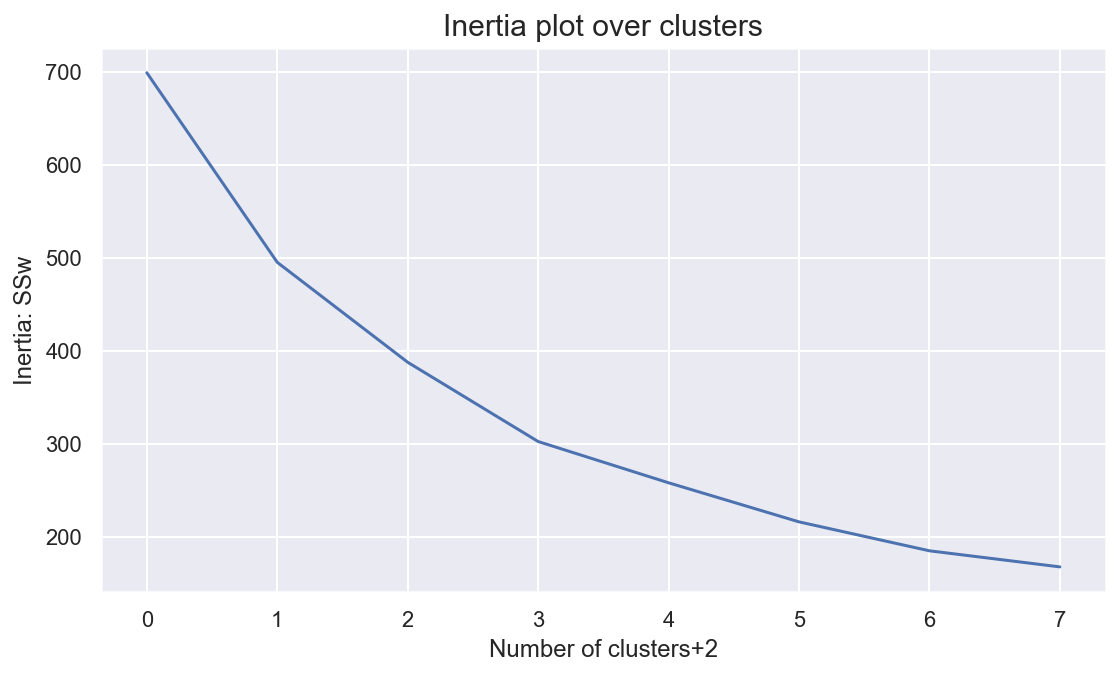

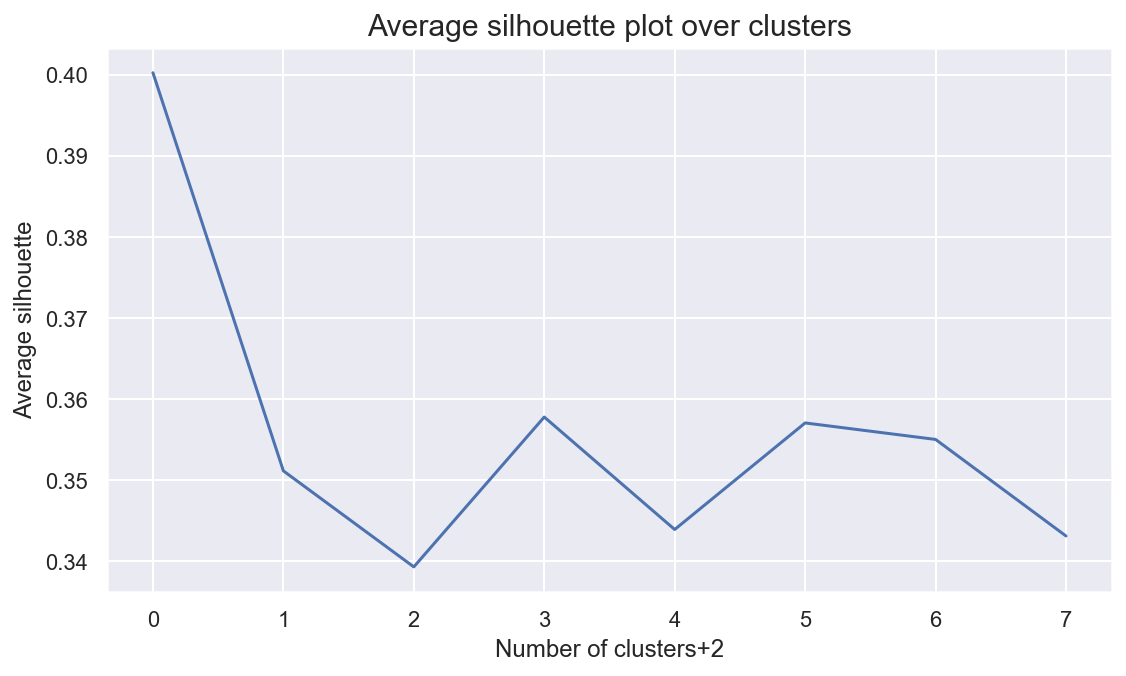

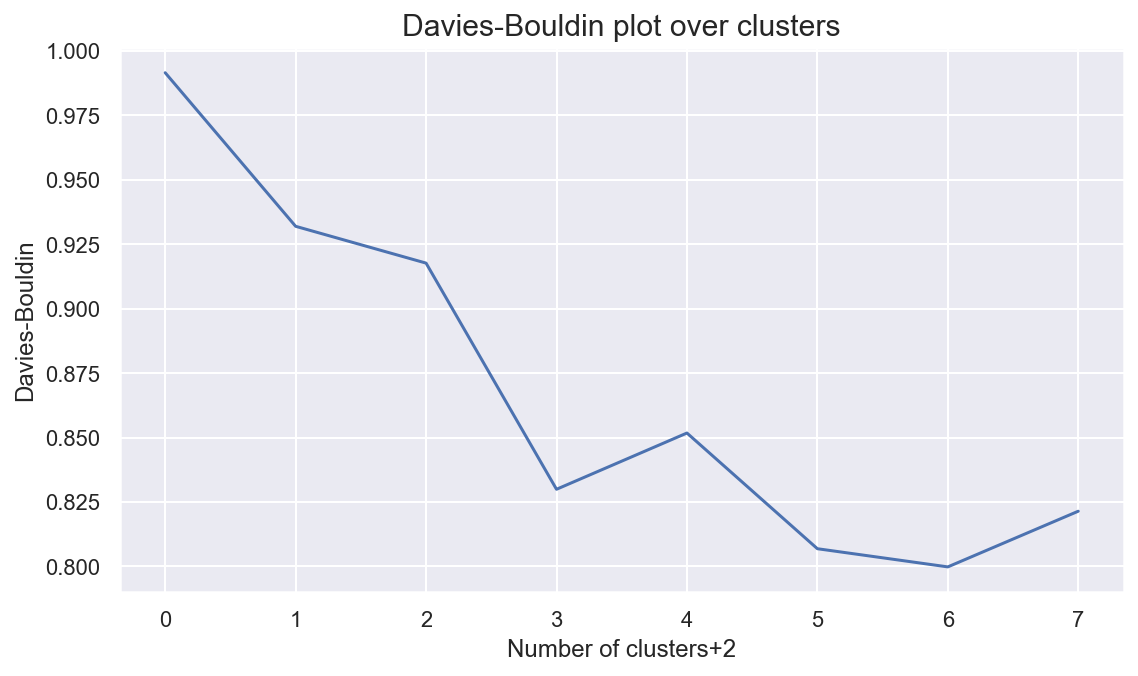

In [17]:
kmeans_elbows_plot(df_cluster_standard, 10)

#### We also ran the silhouette plot that shows a coefficient for the clusters’ quality depending on the number of clusters chosen. We applied in with some possible cluster numbers.

In [18]:
def complete_sh_score(data, k):
    # Storing average silhouette metric
    range_clusters = range(1, k)
    avg_silhouette = []
    for nclus in range_clusters:
        # Skip nclus == 1
        if nclus == 1:
            continue

        # Create a figure
        fig = plt.figure(figsize=(13, 7))

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")

        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])

        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(data) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

For n_clusters = 2, the average silhouette_score is : 0.4002809546161782
For n_clusters = 3, the average silhouette_score is : 0.35116381689231174
For n_clusters = 4, the average silhouette_score is : 0.33931858544204707
For n_clusters = 5, the average silhouette_score is : 0.3578059197517633
For n_clusters = 6, the average silhouette_score is : 0.34392974981413943


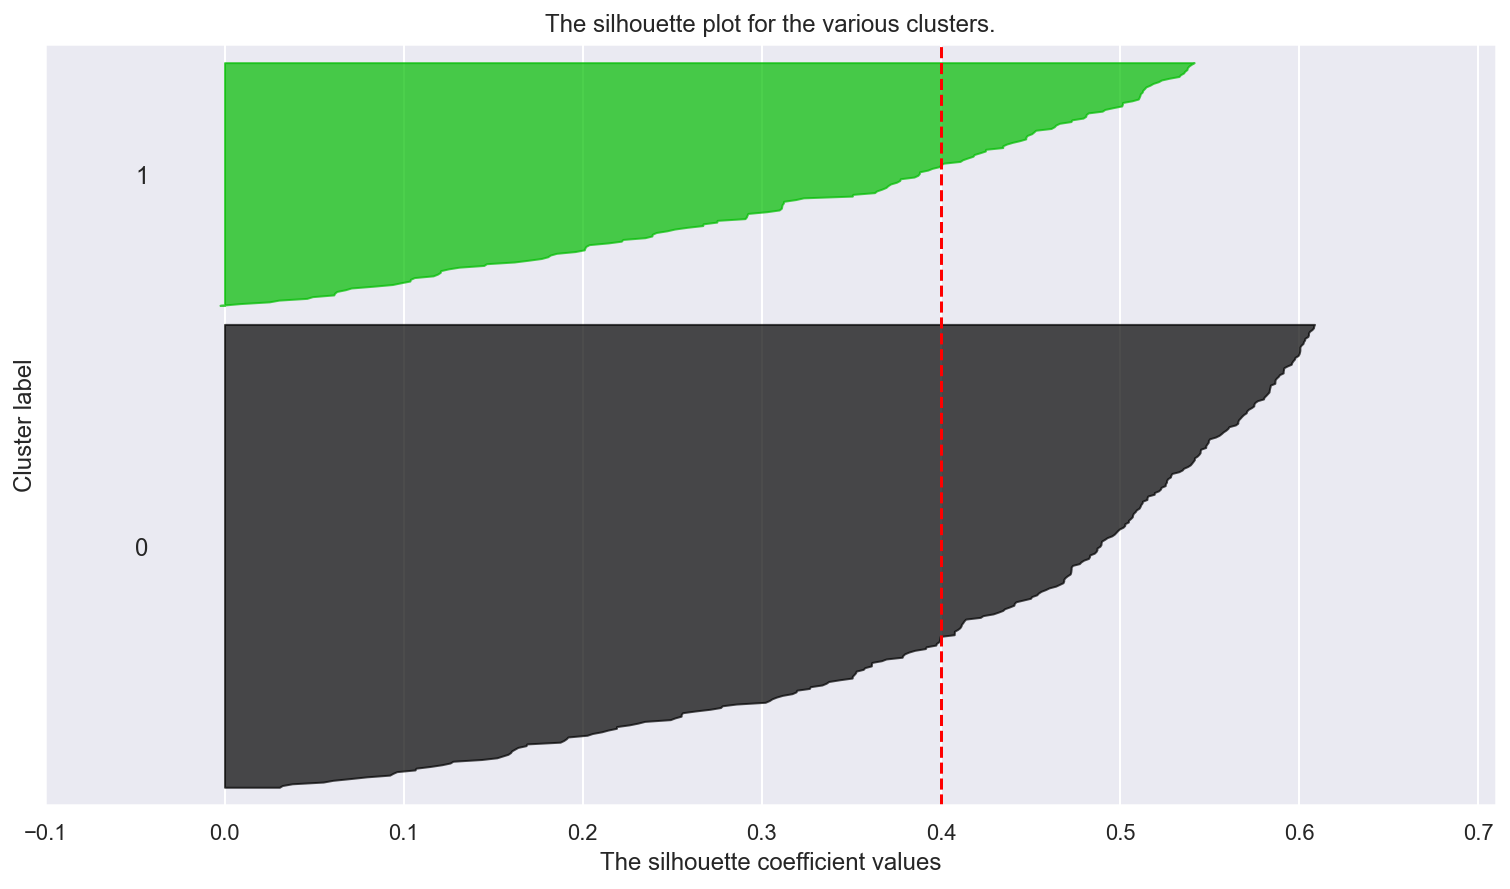

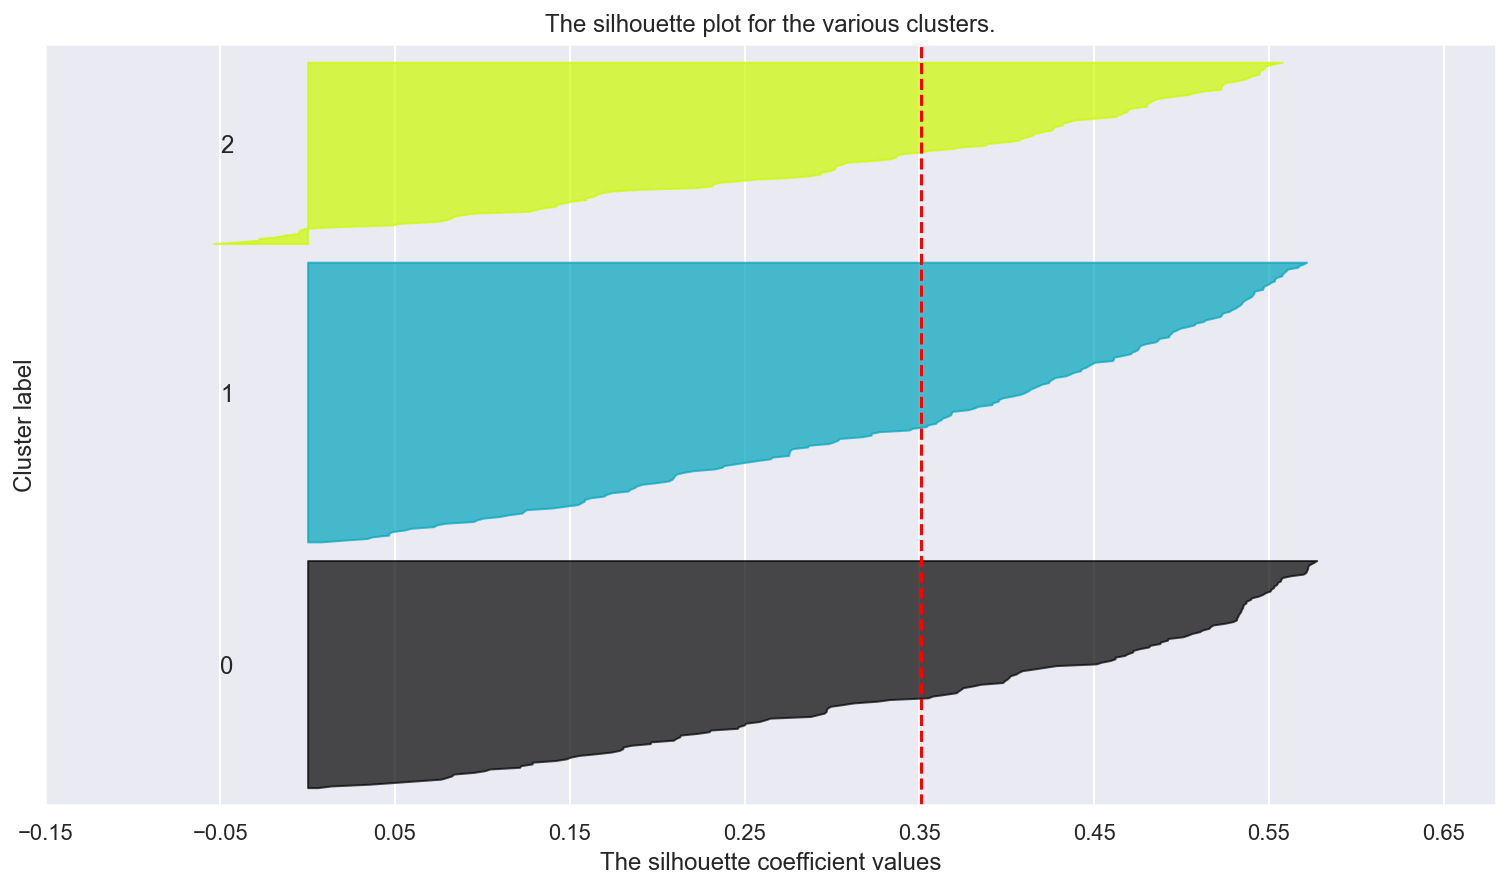

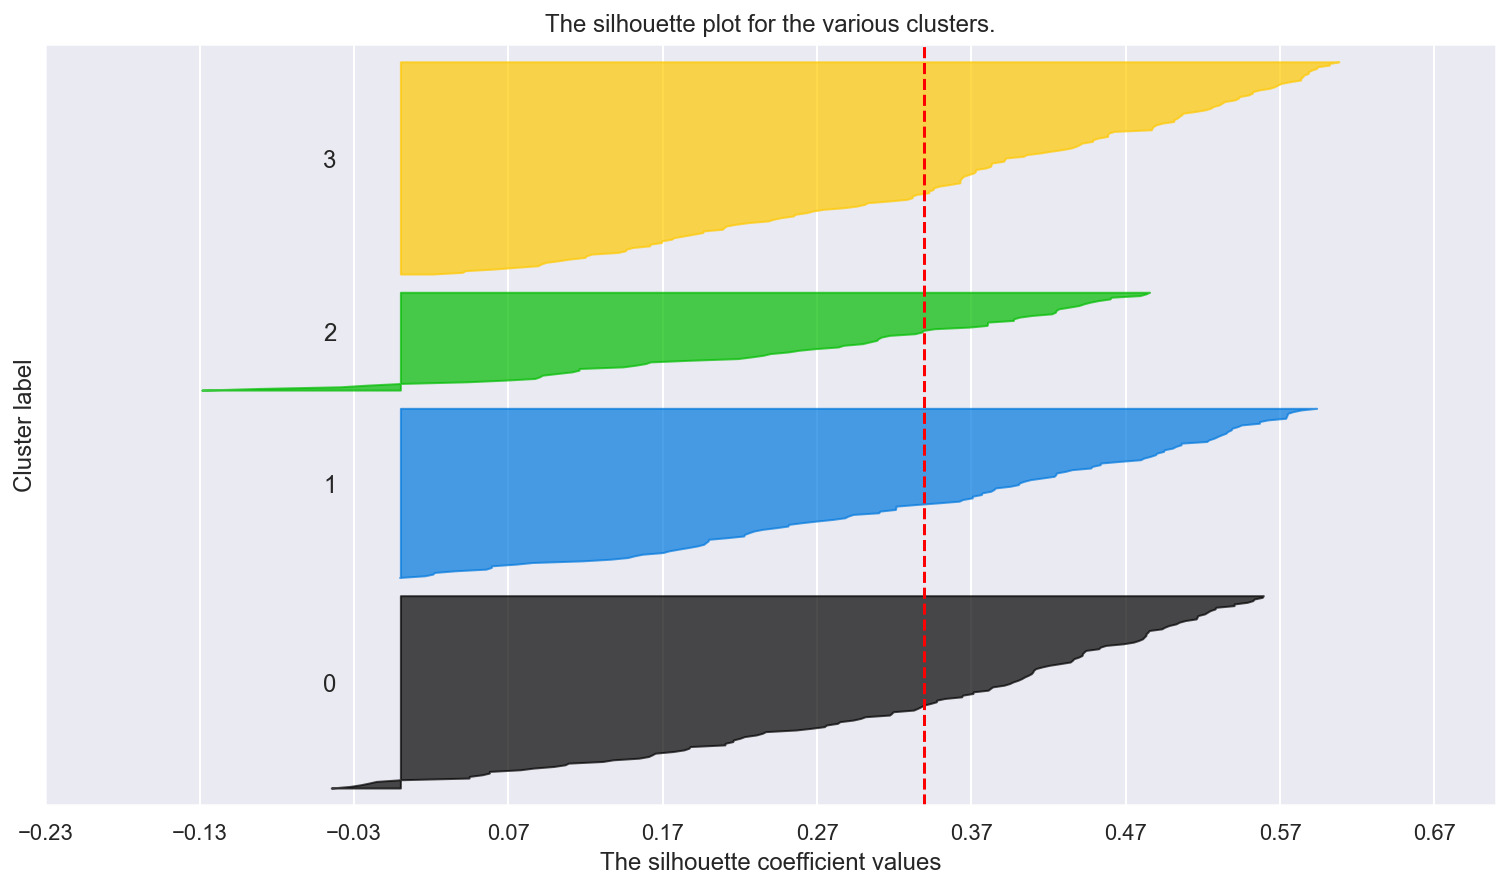

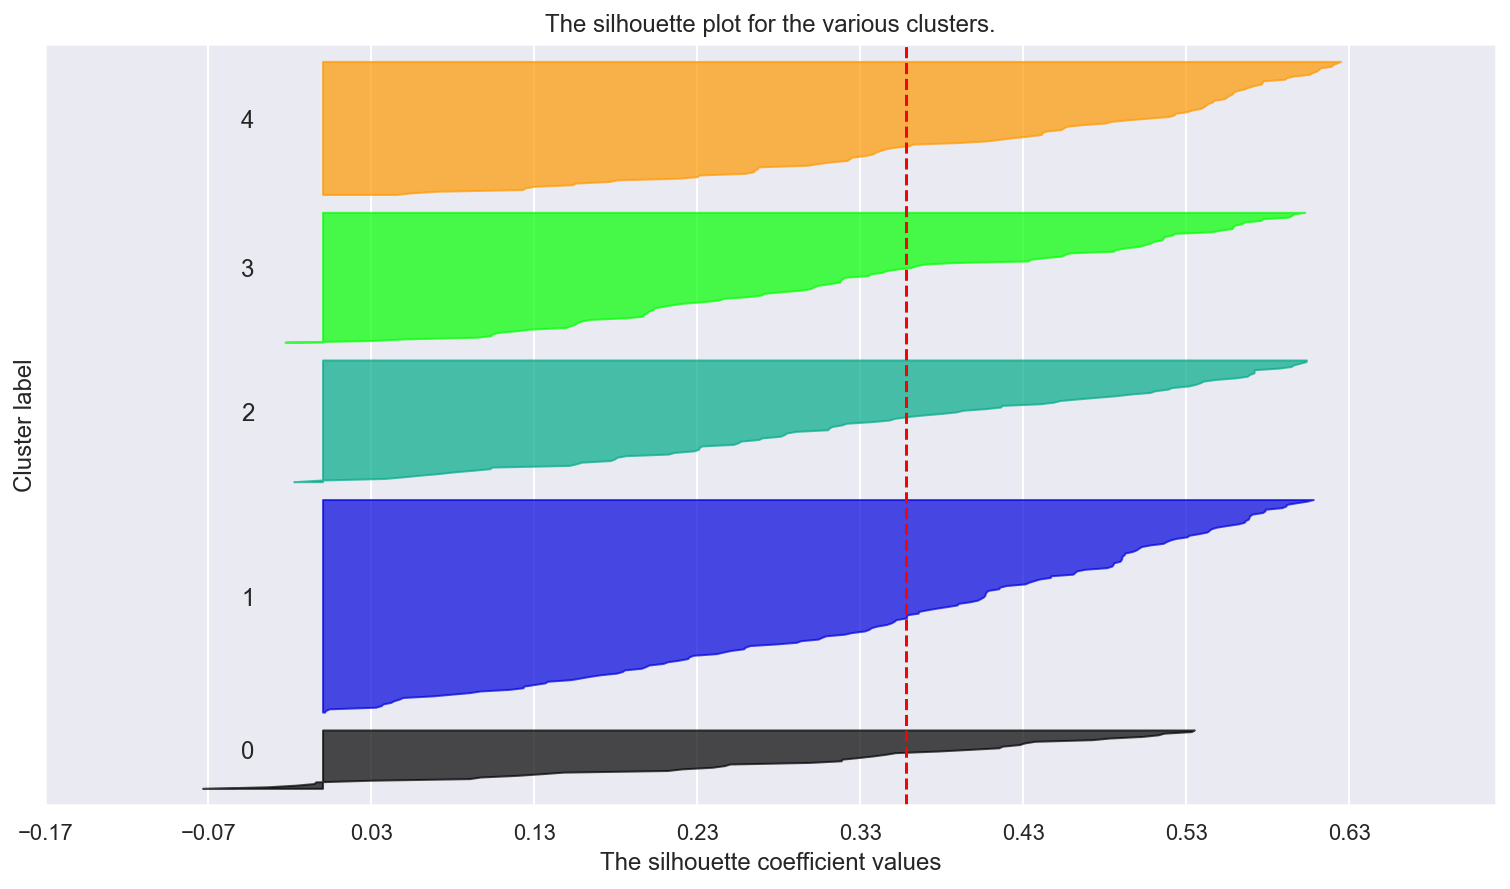

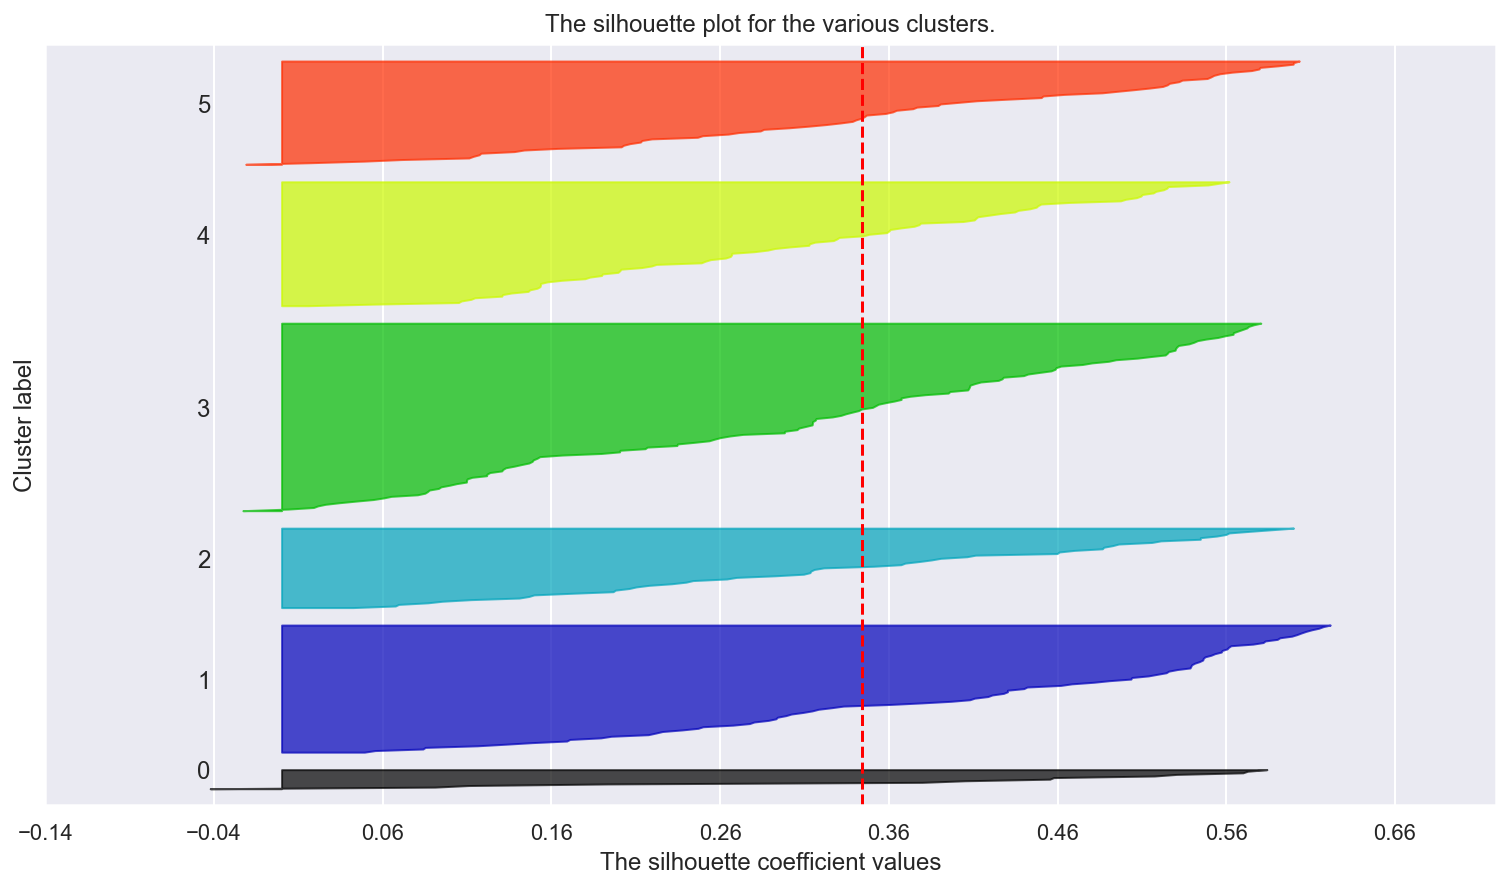

In [19]:
complete_sh_score(df_cluster_standard, 7)

#### After looking to the plots, we decided to proceed with 3 clusters

In [20]:
#We set the ‘k-means++’ as the initialization method (init parameter) 
#with 15 number of iterations to choose the best centroid in terms of inertia (n_init parameter).
kmeans_standard = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=15,
    random_state=1
)
kmeans_standard_labels = kmeans_standard.fit_predict(df_cluster_standard)

In [21]:
#Check the partion cluster
df_cluster_standard['kmeans_standard_labels'] = kmeans_standard_labels
df_cluster_standard.groupby('kmeans_standard_labels').count()

,Quantity,Sales Values,Avg_price
kmeans_standard_labels,,,
0,135,135,135
1,166,166,166
2,108,108,108


## Evaluation

#### The R2 is a measure of the homogenity of a cluster solution. 

In [22]:
#Functions to get the R2.

def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable
def adjusted_r2(df, labels):
    """Return the overall adjusted R-squared"""
    
    # 1. calculate sst
    sst = get_ss(df)
    
    # 2. calculate ssw
    grouped_var = df.groupby(labels).var()
    grouped_count = df.groupby(labels).count() - 1
    ssw = np.sum(np.sum(grouped_var * grouped_count))
    
    # 3. return adjusted R-squared
    return 1 - ssw/sst

In [23]:
#R2 for k-means algorithm
adjusted_r2(df_cluster_standard,kmeans_standard_labels)

0.6627779183188383

#### Describe clusters - Visualizations

In [24]:
def cluster_profiles(df,label_columns, figsize, compar_titles=None, frequency = True):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    if frequency:
        fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    else:
        fig, axes = plt.subplots(nrows=len(label_columns), ncols=1, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        if frequency:    
            sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-90)
        if frequency:
            ax[1].set_xticklabels(cluster_labels)
            ax[1].set_xlabel("")
            ax[1].set_ylabel("Absolute Frequency")
            ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=10)
    plt.show()

In [25]:
# Define metric features
metric_features = ['Quantity','Sales Values','Avg_price']

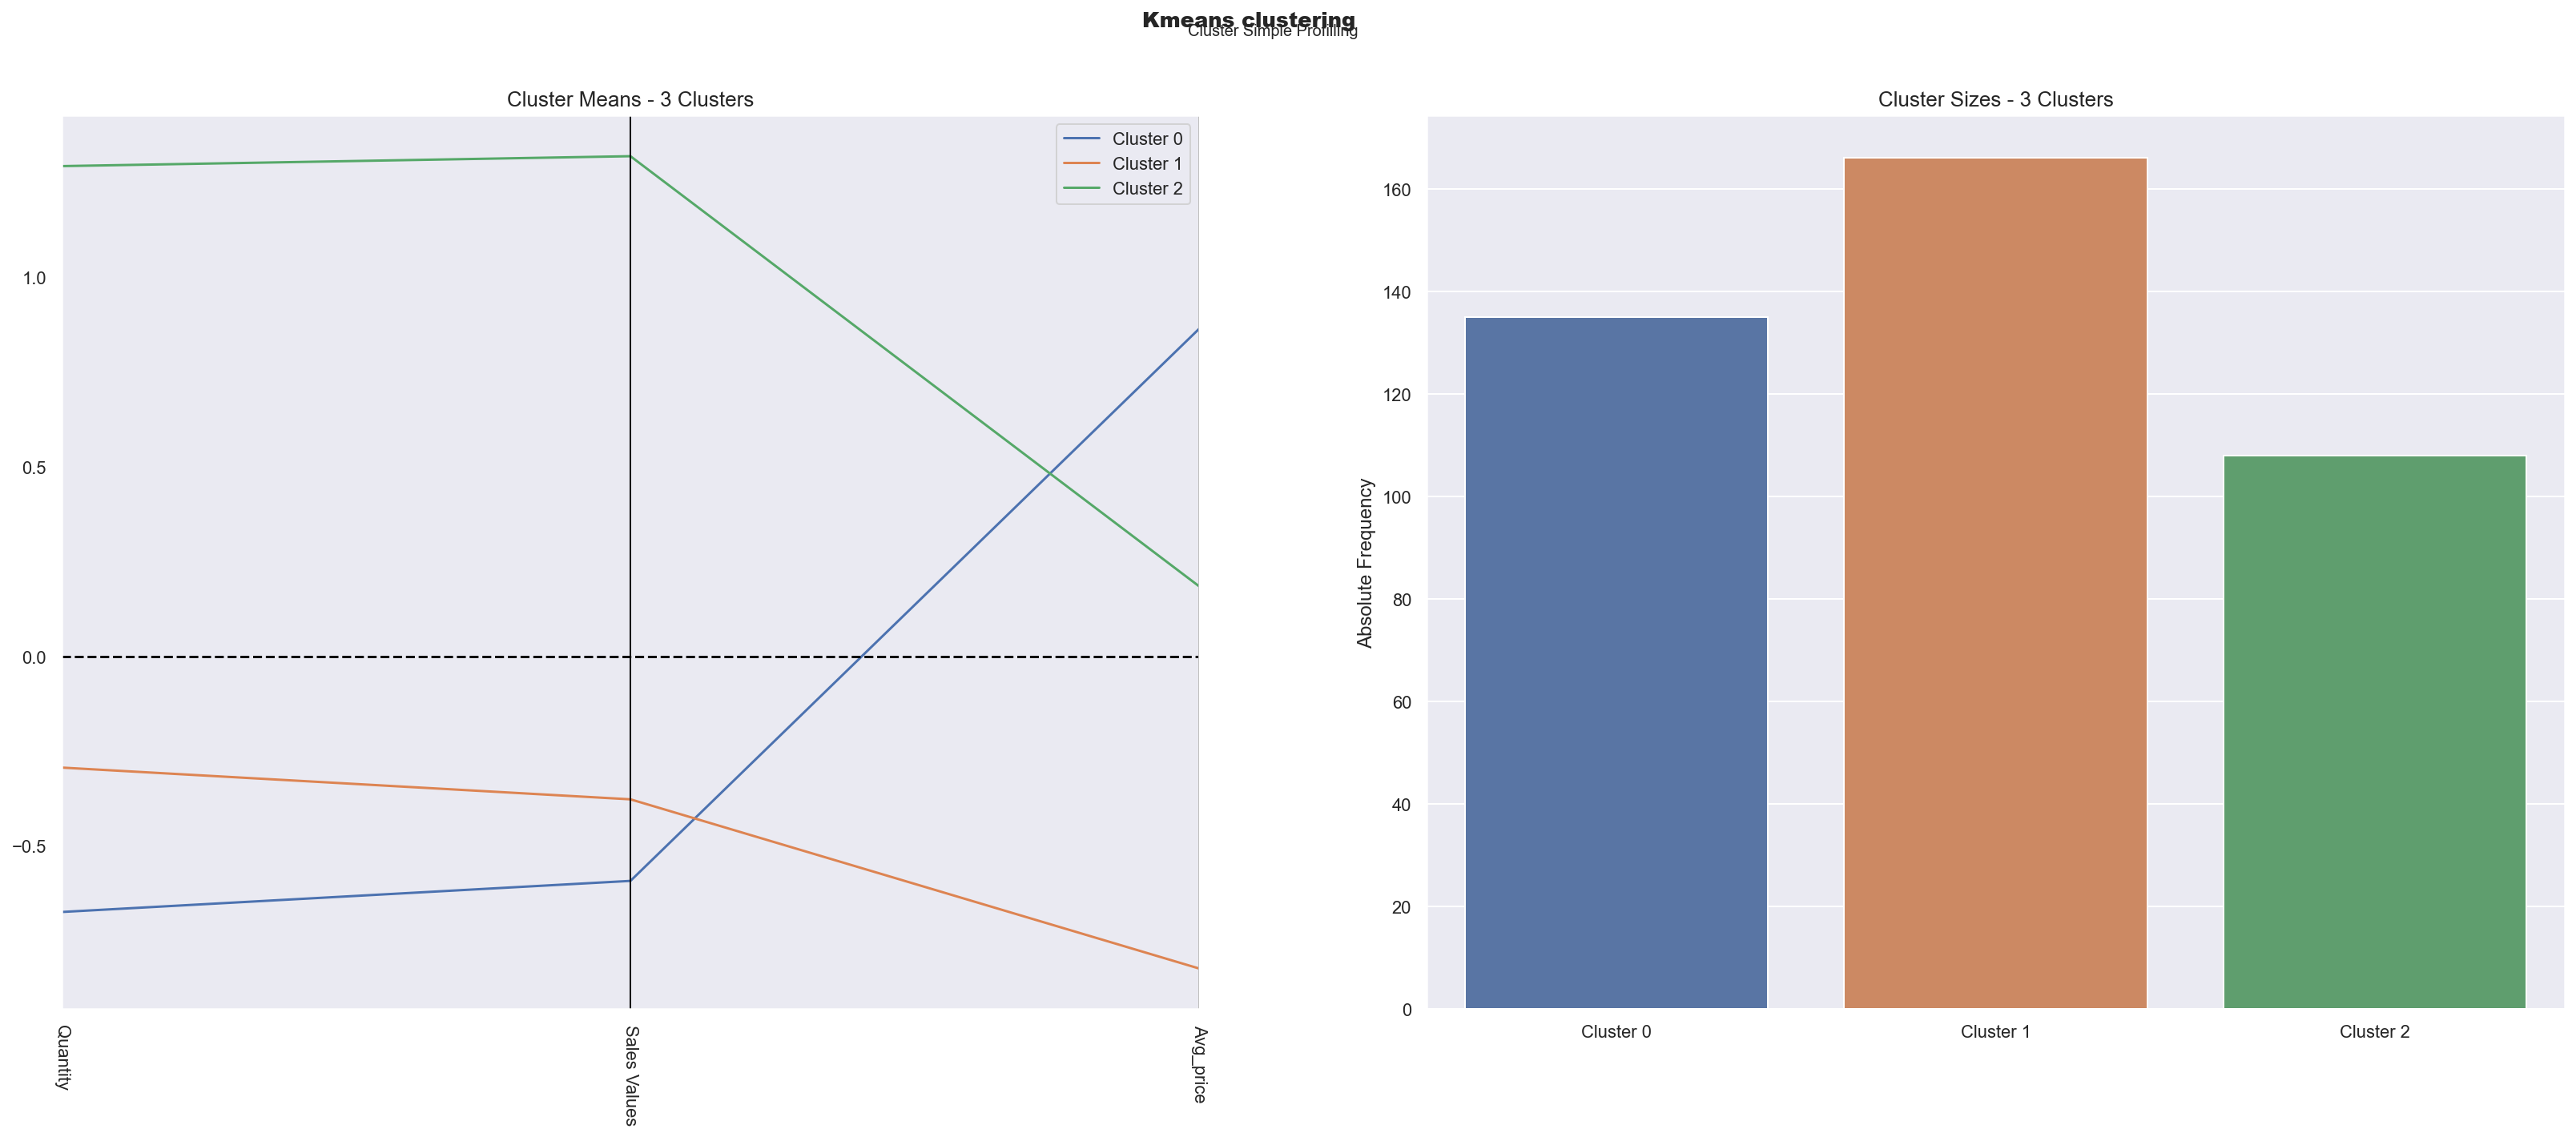

In [26]:
# Profilling cluster
cluster_profiles(
    df = df_cluster_standard[metric_features + ['kmeans_standard_labels']], 
    label_columns = ['kmeans_standard_labels'], 
    figsize = (28, 10), 
    compar_titles = ["Kmeans clustering"]
)

#### T-SNE (t-Distributed Stochastic Neighbor Embedding) is most used for multidimensional visualizations. It has many application but in this work , our objective is visualize clusters within the data and how a cluster solution fits them

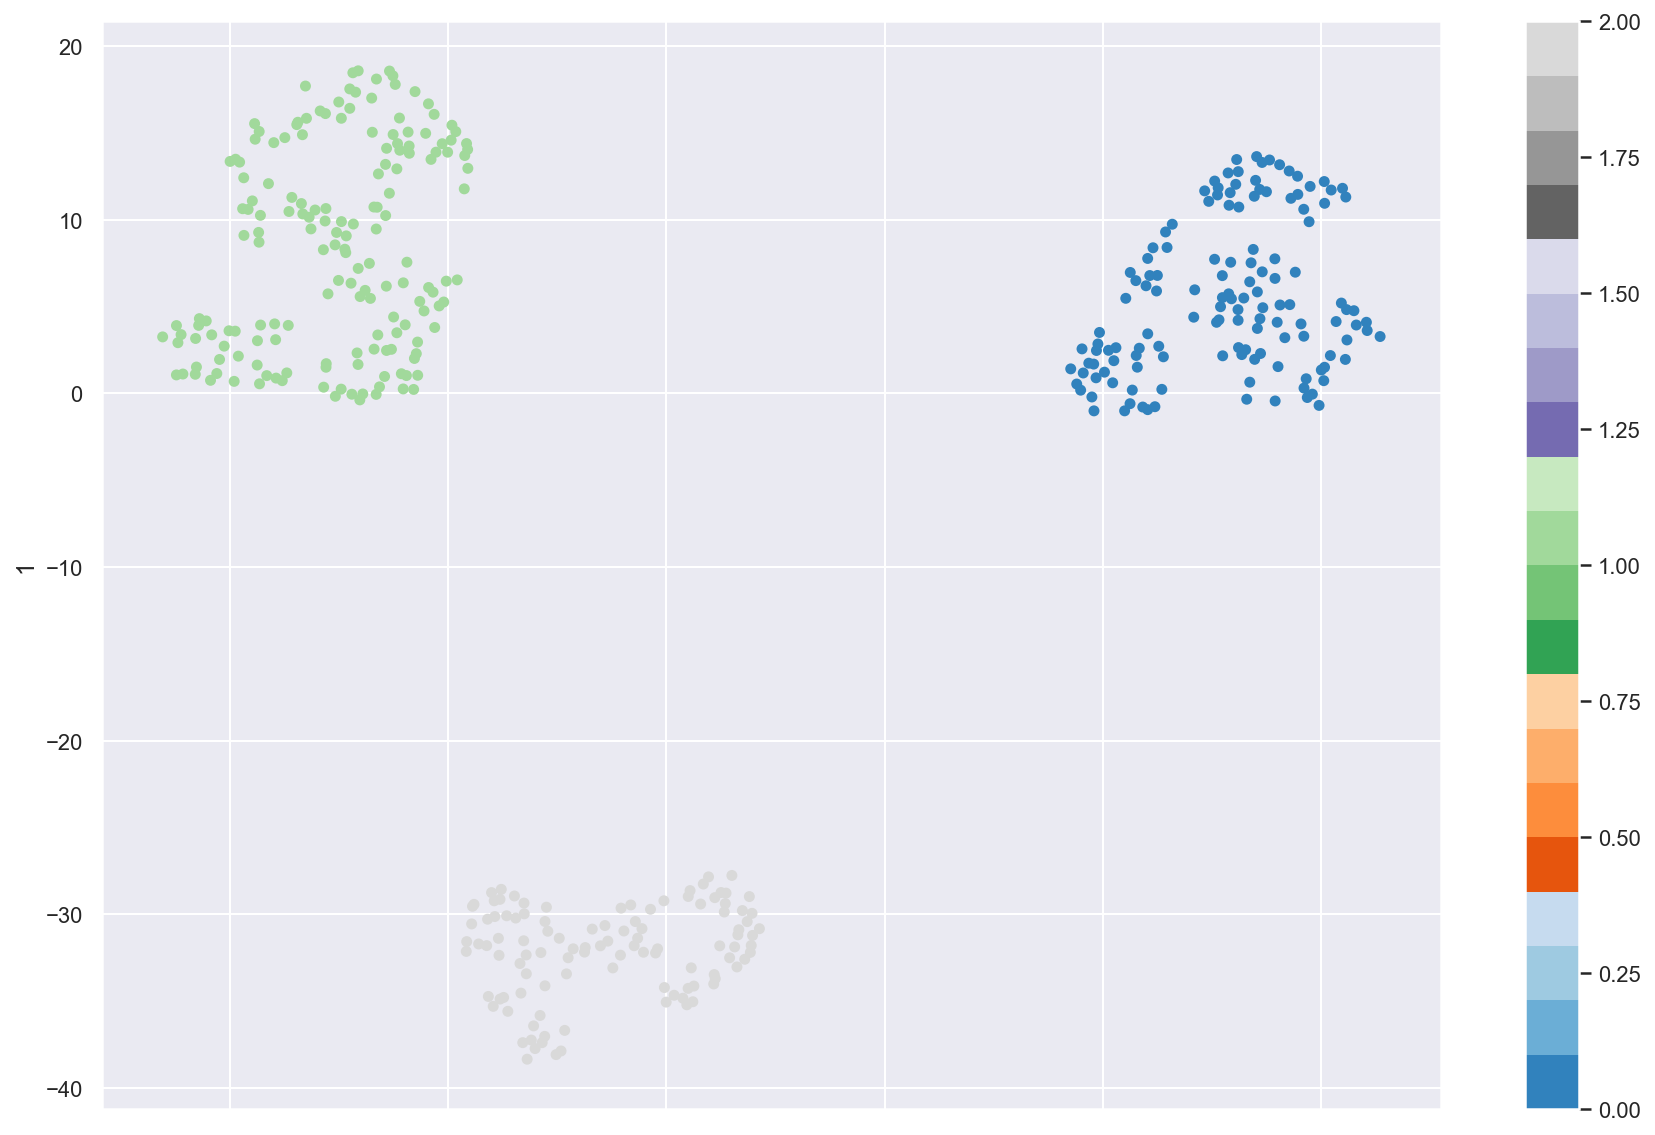

In [27]:
# Run the algorithm, fit and tranform the data
two_dim = TSNE(random_state=42).fit_transform( df_cluster_standard)
#Plot the data
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c= df_cluster_standard['kmeans_standard_labels'], colormap='tab20c', figsize=(15,10))
plt.show()

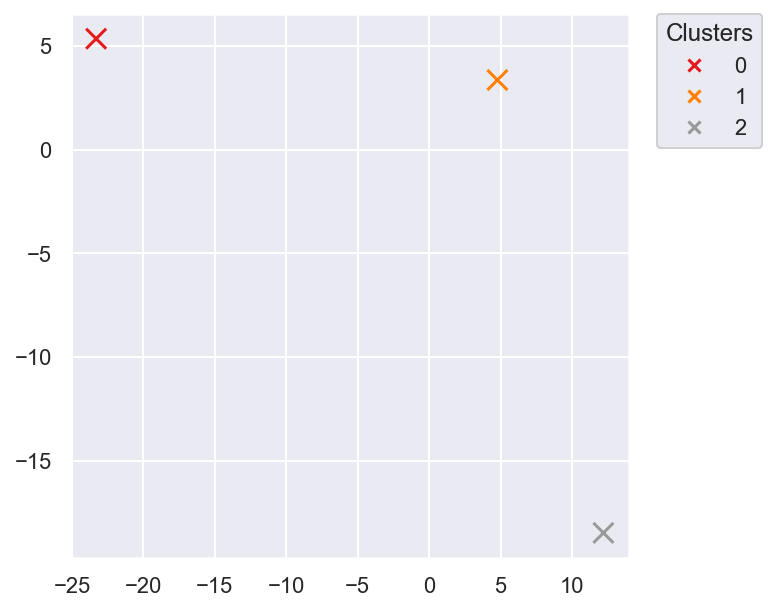

In [28]:
#Visualizing centroids with t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
#Run the algorithm, transform and fit the data
df_tsne = tsne.fit_transform( df_cluster_standard)
#Create a data frame to store the results of tnse
df_tsne = pd.DataFrame(df_tsne, index =  df_cluster_standard.index)\
            .merge(df_cluster_standard['kmeans_standard_labels'], right_index = True, left_index = True)
#Store the centroids
centroids = df_tsne.groupby('kmeans_standard_labels').mean()
#Plot the data
fig, ax = plt.subplots(figsize = (5,5))
data = pd.DataFrame(centroids)
scatter = ax.scatter(x = data.iloc[:,0], y = data.iloc[:,1], c = range(3),marker = 'x', s = 100, cmap = 'Set1')
legend1 = ax.legend(*scatter.legend_elements(), title = 'Clusters', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.add_artist(legend1)
plt.show()

In [29]:
df_cluster_standard

,Quantity,Sales Values,Avg_price,kmeans_standard_labels
Point-of-Sale_ID,,,,
POS_1,0.571847,0.554981,-0.116365,2
POS_10,-1.034023,-1.018300,0.103924,0
POS_100,1.628768,1.499294,-0.599536,2
POS_101,-0.509957,-0.564249,-0.649113,1
POS_102,0.956752,1.035960,0.467219,2
...,...,...,...,...
POS_94,-1.255944,-1.297945,-0.978516,1
POS_95,-0.414880,-0.498969,-0.913254,1
POS_97,-1.072163,-1.198622,-2.148889,1


In [30]:
df_group_cluster = df_group.copy()

In [31]:
df_group_cluster['kmeans_standard_labels']= df_cluster_standard['kmeans_standard_labels']

In [32]:
df_group_cluster

,Quantity,Sales Values,Avg_price,kmeans_standard_labels
Point-of-Sale_ID,,,,
POS_1,607574.0,9.763402e+08,1606.95,2
POS_10,261393.0,4.250743e+08,1626.19,0
POS_100,835417.0,1.307221e+09,1564.75,2
POS_101,374367.0,5.841704e+08,1560.42,1
POS_102,690549.0,1.144872e+09,1657.92,2
...,...,...,...,...
POS_94,213553.0,3.270889e+08,1531.65,1
POS_95,394863.0,6.070441e+08,1537.35,1
POS_97,253171.0,3.618910e+08,1429.43,1


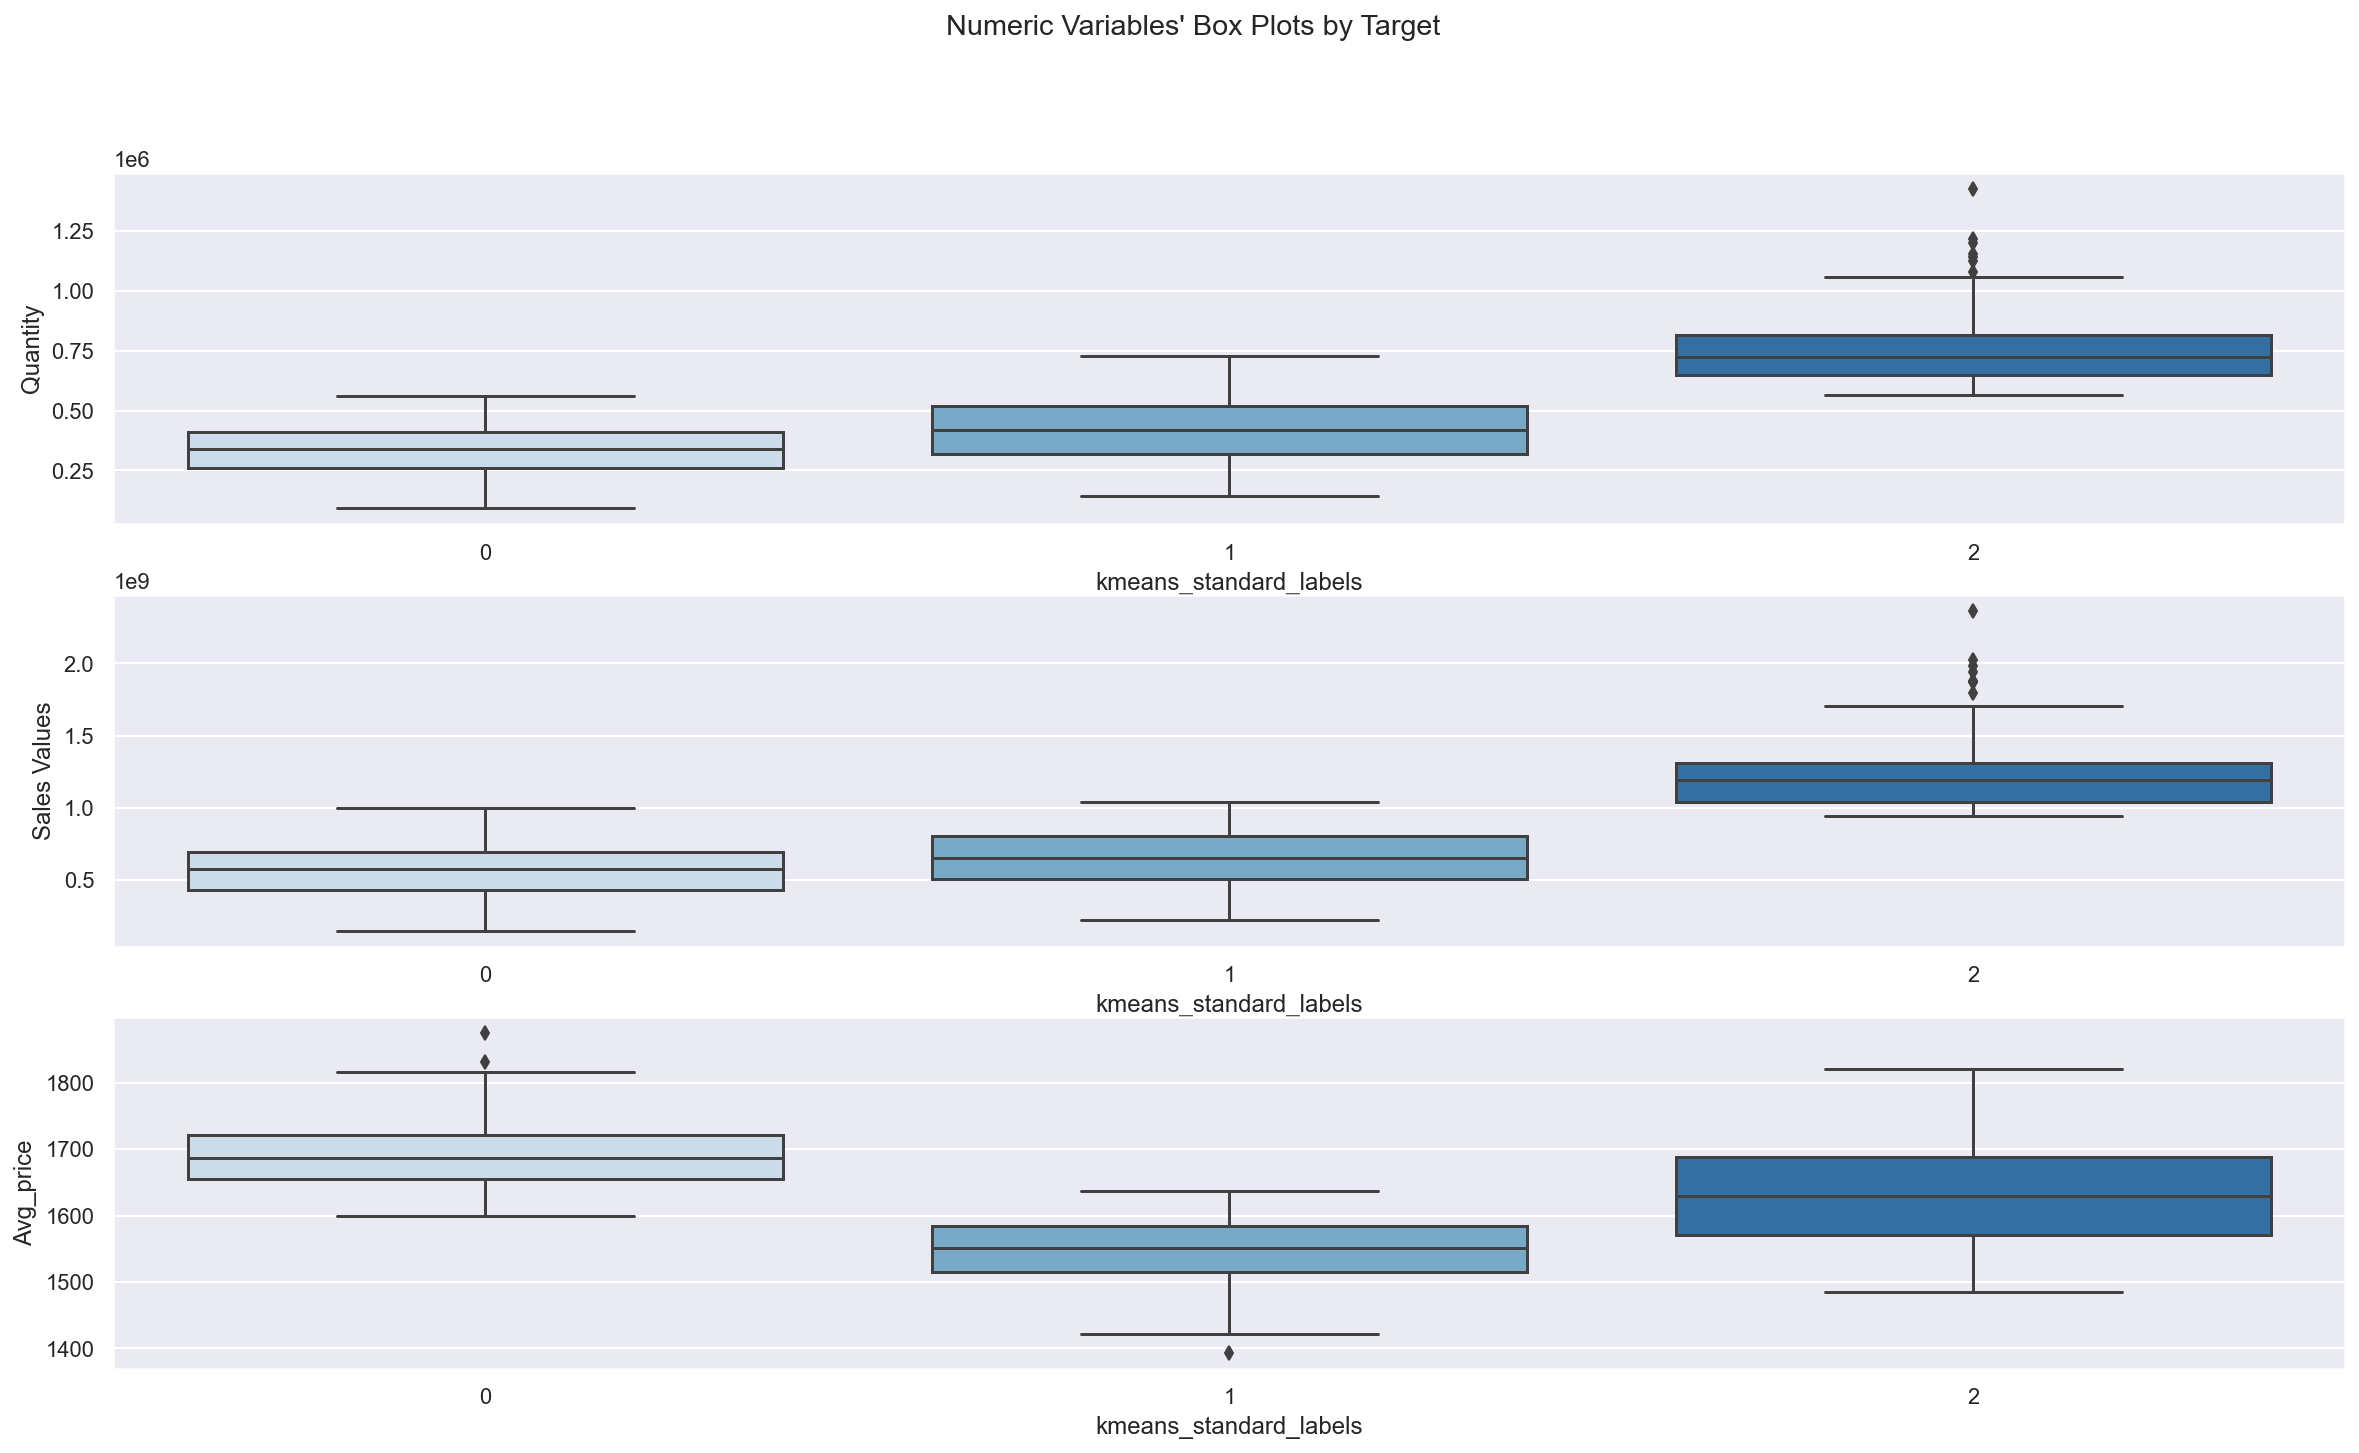

In [33]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df_group_cluster['kmeans_standard_labels'], y=df_group_cluster[feat], ax=ax,palette="Blues")
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots by Target"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.3)

# Remove the last graphic
#axes.flatten()[-1].remove()

plt.show()

In [34]:
df_group_cluster.reset_index(inplace = True)

In [35]:
df_group_cluster.rename(columns = {'kmeans_standard_labels':'Cluster_Value'}, inplace = True)
df_group_cluster

,Point-of-Sale_ID,Quantity,Sales Values,Avg_price,Cluster_Value
0,POS_1,607574.0,9.763402e+08,1606.95,2
1,POS_10,261393.0,4.250743e+08,1626.19,0
2,POS_100,835417.0,1.307221e+09,1564.75,2
3,POS_101,374367.0,5.841704e+08,1560.42,1
4,POS_102,690549.0,1.144872e+09,1657.92,2
...,...,...,...,...,...
404,POS_94,213553.0,3.270889e+08,1531.65,1
405,POS_95,394863.0,6.070441e+08,1537.35,1
406,POS_97,253171.0,3.618910e+08,1429.43,1
407,POS_98,331261.0,5.474936e+08,1652.76,0


In [36]:
df_group_cluster_value = df_group_cluster[['Point-of-Sale_ID', 'Cluster_Value' ]]

In [37]:
df_group_cluster_value.to_csv(os.path.join("dfcluster_value .csv"), index=False)

### CLUSTER BASED ON PREFERENCES

#### CLUSTER BY PRODUCT CATEGORY

In [38]:
df

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values
0,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,2.0,1540.0
1,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,4.0,3080.0
2,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,2.0,1540.0
3,ProductName_649,ProductSKU_1970,POS_1,2017-10-13,2.0,1620.0
4,ProductName_649,ProductSKU_1970,POS_1,2017-10-14,2.0,1620.0
...,...,...,...,...,...,...
90748390,ProductName_2367,ProductSKU_7297,POS_82,2019-06-12,1.0,765.0
90748391,ProductName_457,ProductSKU_1471,POS_158,2018-07-17,1.0,5150.0
90748392,ProductName_457,ProductSKU_1471,POS_158,2018-07-19,1.0,5150.0
90748393,ProductName_457,ProductSKU_1471,POS_158,2019-08-27,1.0,5150.0


In [39]:
#import dataset in csv
df_prod = pd.read_csv('product_hierarchy.csv')

In [40]:
df_prod.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID
0,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970
1,Family_6,Category_178,ProductBrand_744,ProductName_1422,ProductSKU_4422
2,Family_6,Category_178,ProductBrand_744,ProductName_1422,ProductSKU_4424
3,Family_1,Category_33,ProductBrand_1092,ProductName_2008,ProductSKU_6100
4,Family_12,Category_178,ProductBrand_506,ProductName_1014,ProductSKU_3054


In [41]:
df_merge = pd.merge(df,df_prod,on='ProductPackSKU_ID')

In [42]:
df_merge

,ProductName_ID_x,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID_y
0,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,2.0,1540.0,Family_16,Category_11,ProductBrand_306,ProductName_649
1,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,4.0,3080.0,Family_16,Category_11,ProductBrand_306,ProductName_649
2,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,2.0,1540.0,Family_16,Category_11,ProductBrand_306,ProductName_649
3,ProductName_649,ProductSKU_1970,POS_1,2017-10-13,2.0,1620.0,Family_16,Category_11,ProductBrand_306,ProductName_649
4,ProductName_649,ProductSKU_1970,POS_1,2017-10-14,2.0,1620.0,Family_16,Category_11,ProductBrand_306,ProductName_649
...,...,...,...,...,...,...,...,...,...,...
90748390,ProductName_2367,ProductSKU_7297,POS_82,2019-06-12,1.0,765.0,Family_16,Category_11,ProductBrand_1260,ProductName_2367
90748391,ProductName_457,ProductSKU_1471,POS_158,2018-07-17,1.0,5150.0,Family_21,Category_132,ProductBrand_220,ProductName_457
90748392,ProductName_457,ProductSKU_1471,POS_158,2018-07-19,1.0,5150.0,Family_21,Category_132,ProductBrand_220,ProductName_457
90748393,ProductName_457,ProductSKU_1471,POS_158,2019-08-27,1.0,5150.0,Family_21,Category_132,ProductBrand_220,ProductName_457


In [43]:
df_pref = pd.DataFrame(df_merge.groupby(['Point-of-Sale_ID', 'ProductCategory_ID'])['Quantity'].sum())

In [44]:
df_pref.reset_index(inplace = True)

In [45]:
df_pref.set_index(['Point-of-Sale_ID'],inplace=True)
df_pref

,ProductCategory_ID,Quantity
Point-of-Sale_ID,,
POS_1,Category_1,4559.0
POS_1,Category_10,3912.0
POS_1,Category_100,17.0
POS_1,Category_101,45.0
POS_1,Category_108,12.0
...,...,...
POS_99,Category_93,3.0
POS_99,Category_94,107.0
POS_99,Category_95,8.0


In [46]:
df_pref_group = pd.DataFrame(df_merge.groupby(['Point-of-Sale_ID', 'ProductCategory_ID'])['Quantity'].sum().unstack(fill_value=0))

In [47]:
df_pref_group= df_pref_group.reset_index()
df_pref_group

ProductCategory_ID,Point-of-Sale_ID,Category_1,Category_10,Category_100,Category_101,Category_102,Category_103,Category_104,Category_105,Category_106,...,Category_9,Category_91,Category_92,Category_93,Category_94,Category_95,Category_96,Category_97,Category_98,Category_99
0,POS_1,4559.0,3912.0,17.0,45.0,0.0,0.0,0.0,0.0,0.0,...,1432.0,138.0,280.0,0.0,119.0,9.0,27.0,88.0,21.0,0.0
1,POS_10,2342.0,1555.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,...,228.0,73.0,67.0,0.0,4.0,17.0,0.0,14.0,0.0,0.0
2,POS_100,4318.0,3510.0,24.0,120.0,3.0,0.0,0.0,24.0,0.0,...,998.0,244.0,282.0,6.0,31.0,26.0,5.0,58.0,8.0,0.0
3,POS_101,1812.0,1132.0,38.0,78.0,2.0,0.0,0.0,39.0,0.0,...,240.0,122.0,142.0,0.0,44.0,4.0,8.0,22.0,0.0,0.0
4,POS_102,3701.0,1152.0,31.0,70.0,7.0,0.0,3.0,2.0,0.0,...,868.0,378.0,323.0,1.0,83.0,67.0,23.0,122.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,POS_94,1359.0,1513.0,33.0,79.0,2.0,0.0,0.0,18.0,0.0,...,291.0,84.0,132.0,3.0,50.0,44.0,21.0,35.0,0.0,0.0
405,POS_95,2656.0,1718.0,16.0,66.0,7.0,0.0,0.0,2.0,1.0,...,567.0,173.0,406.0,7.0,67.0,21.0,45.0,37.0,0.0,0.0
406,POS_97,1169.0,791.0,0.0,10.0,0.0,0.0,0.0,1.0,2.0,...,307.0,50.0,101.0,0.0,20.0,9.0,9.0,16.0,2.0,0.0
407,POS_98,1376.0,977.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,430.0,79.0,81.0,1.0,8.0,1.0,0.0,70.0,0.0,0.0


In [48]:
df_pref_group.set_index('Point-of-Sale_ID',inplace = True)
df_pref_group

ProductCategory_ID,Category_1,Category_10,Category_100,Category_101,Category_102,Category_103,Category_104,Category_105,Category_106,Category_108,...,Category_9,Category_91,Category_92,Category_93,Category_94,Category_95,Category_96,Category_97,Category_98,Category_99
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
POS_1,4559.0,3912.0,17.0,45.0,0.0,0.0,0.0,0.0,0.0,12.0,...,1432.0,138.0,280.0,0.0,119.0,9.0,27.0,88.0,21.0,0.0
POS_10,2342.0,1555.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,6.0,...,228.0,73.0,67.0,0.0,4.0,17.0,0.0,14.0,0.0,0.0
POS_100,4318.0,3510.0,24.0,120.0,3.0,0.0,0.0,24.0,0.0,266.0,...,998.0,244.0,282.0,6.0,31.0,26.0,5.0,58.0,8.0,0.0
POS_101,1812.0,1132.0,38.0,78.0,2.0,0.0,0.0,39.0,0.0,30.0,...,240.0,122.0,142.0,0.0,44.0,4.0,8.0,22.0,0.0,0.0
POS_102,3701.0,1152.0,31.0,70.0,7.0,0.0,3.0,2.0,0.0,204.0,...,868.0,378.0,323.0,1.0,83.0,67.0,23.0,122.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POS_94,1359.0,1513.0,33.0,79.0,2.0,0.0,0.0,18.0,0.0,2.0,...,291.0,84.0,132.0,3.0,50.0,44.0,21.0,35.0,0.0,0.0
POS_95,2656.0,1718.0,16.0,66.0,7.0,0.0,0.0,2.0,1.0,38.0,...,567.0,173.0,406.0,7.0,67.0,21.0,45.0,37.0,0.0,0.0
POS_97,1169.0,791.0,0.0,10.0,0.0,0.0,0.0,1.0,2.0,3.0,...,307.0,50.0,101.0,0.0,20.0,9.0,9.0,16.0,2.0,0.0


In [49]:
df_pref_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, POS_1 to POS_99
Columns: 168 entries, Category_1 to Category_99
dtypes: float64(168)
memory usage: 540.0+ KB


In [50]:
#Create a copy
df_standard=df_pref_group.copy()

In [51]:
#Select data
features = df_standard.columns
# Create a StandardScaler
scale = StandardScaler()
# Fit and Transform data by applying the scale obtained in the previous command
scale_feat= scale.fit_transform(df_standard[features])
#Applying the transformation in the dataset
df_standard[features]=scale_feat
#Check the results
df_standard.head()

ProductCategory_ID,Category_1,Category_10,Category_100,Category_101,Category_102,Category_103,Category_104,Category_105,Category_106,Category_108,...,Category_9,Category_91,Category_92,Category_93,Category_94,Category_95,Category_96,Category_97,Category_98,Category_99
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
POS_1,0.922340,0.752500,0.110132,-0.410288,-0.771820,-0.167303,-0.219865,-0.571961,-0.480793,-0.519013,...,1.201445,-0.453321,-0.322931,-0.658880,0.086455,-0.568530,-0.097967,0.415967,4.931514,-0.08374
POS_10,-0.398335,-0.470589,-0.621239,-0.567693,-0.771820,-0.167303,-0.219865,-0.571961,-0.480793,-0.550888,...,-0.876471,-0.729170,-0.573538,-0.658880,-0.753716,-0.455025,-0.836937,-0.729797,-0.310661,-0.08374
POS_100,0.778776,0.543896,0.411284,-0.063071,-0.110952,-0.167303,-0.219865,0.394867,-0.480793,0.830359,...,0.452428,-0.003476,-0.320577,0.324631,-0.556459,-0.327332,-0.700091,-0.048532,1.686358,-0.08374
POS_101,-0.714058,-0.690091,1.013589,-0.257512,-0.331242,-0.167303,-0.219865,0.999135,-0.480793,-0.423389,...,-0.855761,-0.521222,-0.485296,-0.658880,-0.461483,-0.639470,-0.617983,-0.605931,-0.310661,-0.08374
POS_102,0.411226,-0.679712,0.712436,-0.294549,0.770204,-0.167303,1.077127,-0.491392,-0.480793,0.500985,...,0.228069,0.565196,-0.272338,-0.494962,-0.176555,0.254380,-0.207444,0.942399,1.187103,-0.08374


In [52]:
#Check the statistics summary
df_standard.describe().apply(lambda s: s.apply(lambda x:format(x,'g')))

ProductCategory_ID,Category_1,Category_10,Category_100,Category_101,Category_102,Category_103,Category_104,Category_105,Category_106,Category_108,...,Category_9,Category_91,Category_92,Category_93,Category_94,Category_95,Category_96,Category_97,Category_98,Category_99
count,409,409,409,409,409,409,409,409,409,409,...,409,409,409,409,409,409,409,409,409,409
mean,-7.872e-18,-7.24088e-17,-6.51476e-18,-5.35432e-17,-8.6592e-17,1.54318e-16,-1.32331e-16,-6.96943e-17,1.14076e-16,-1.36538e-16,...,6.89478e-17,-1.10547e-16,3.90885e-17,7.18659e-17,6.63776e-18,4.7232e-17,-2.15462e-18,1.3681e-16,1.20794e-16,-2.12748e-16
std,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,...,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122
min,-1.49383,-1.24948,-0.621239,-0.618618,-0.77182,-0.167303,-0.219865,-0.571961,-0.480793,-0.582763,...,-1.2458,-1.03897,-0.651192,-0.65888,-0.78294,-0.696223,-0.836937,-0.946563,-0.310661,-0.0837401
25%,-0.746226,-0.653767,-0.621239,-0.521397,-0.77182,-0.167303,-0.219865,-0.571961,-0.480793,-0.519013,...,-0.728049,-0.640049,-0.533535,-0.65888,-0.578376,-0.554342,-0.617983,-0.652381,-0.310661,-0.0837401
50%,-0.172563,-0.219951,-0.40613,-0.354733,-0.331242,-0.167303,-0.219865,-0.491392,-0.480793,-0.375576,...,-0.263797,-0.292056,-0.32999,-0.494962,-0.351895,-0.313144,-0.316921,-0.296265,-0.310661,-0.0837401
75%,0.472584,0.395485,0.196175,0.0897048,0.329626,-0.167303,-0.219865,0.193444,-0.0535375,0.0759855,...,0.461058,0.348761,0.142988,0.160712,0.217961,0.226004,0.230464,0.292101,-0.310661,-0.0837401
max,6.38971,5.84205,7.33779,8.42755,5.83685,11.563,9.29141,6.39726,9.4529,9.2719,...,6.04071,6.18402,8.95897,6.06178,6.88089,8.42672,8.24966,6.08285,8.92555,18.1828


In [53]:
#Create a copy only with metric features to run the cluster.
#To run the clustering solutions, we selected only numerical features. 
df_cluster_pref = df_standard.copy()

In [54]:
def kmeans_elbows_plot(data, k):

    K = range(2, k) 

    inertia = []
    avg_silhouette = []
    db_scores =[]
    for k in K:
        kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=1)
        kmeanModel.fit(data)
        clusters = kmeanModel.labels_
        inertia.append(kmeanModel.inertia_)
        avg_silhouette.append(silhouette_score(data, clusters))
        db_scores.append(davies_bouldin_score(data, clusters))

    # The inertia plot
    plt.figure(figsize=(9,5))
    plt.plot(inertia)
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters+2")
    plt.title("Inertia plot over clusters", size=15)
    plt.show()

    # The average silhouette plot
    plt.figure(figsize=(9,5))
    plt.plot(avg_silhouette)
    plt.ylabel("Average silhouette")
    plt.xlabel("Number of clusters+2")
    plt.title("Average silhouette plot over clusters", size=15)
    plt.show()

    # The Davies Bouldin score
    plt.figure(figsize=(9,5))
    plt.plot(db_scores)
    plt.ylabel("Davies-Bouldin")
    plt.xlabel("Number of clusters+2")
    plt.title("Davies-Bouldin plot over clusters", size=15)
    plt.show()

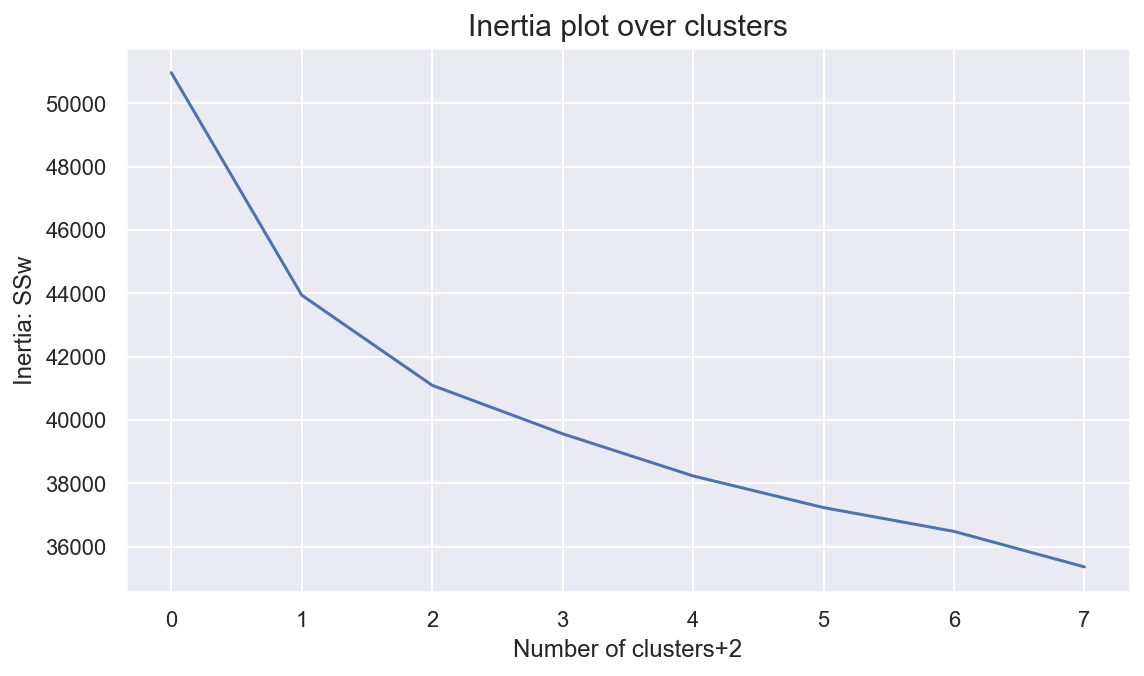

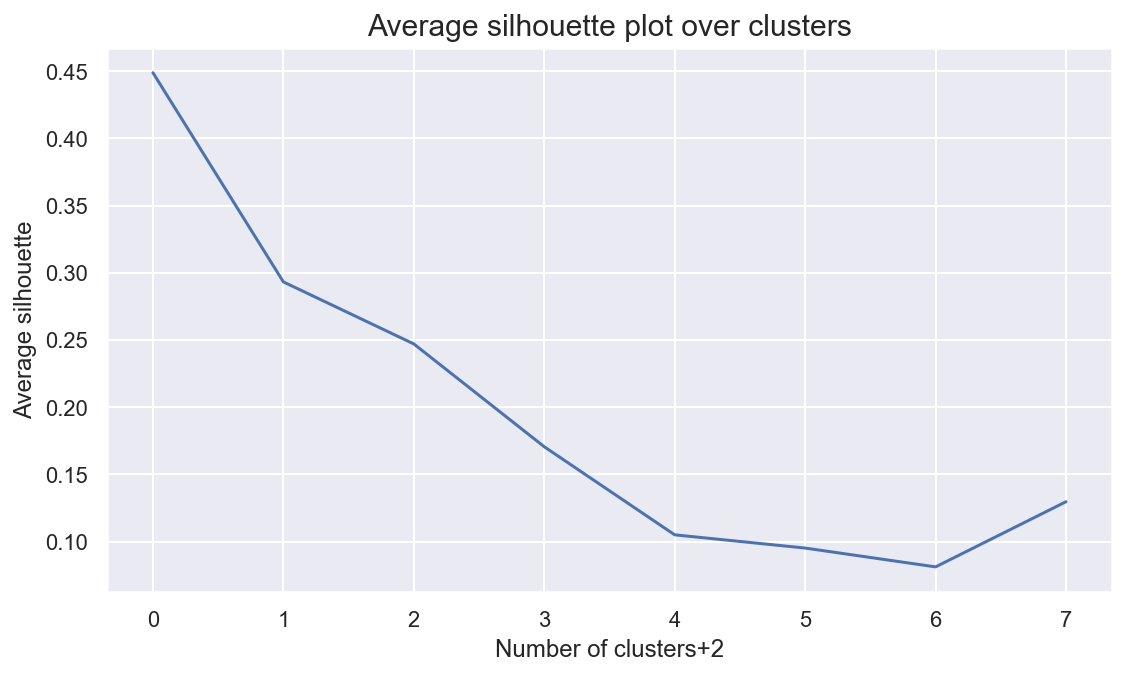

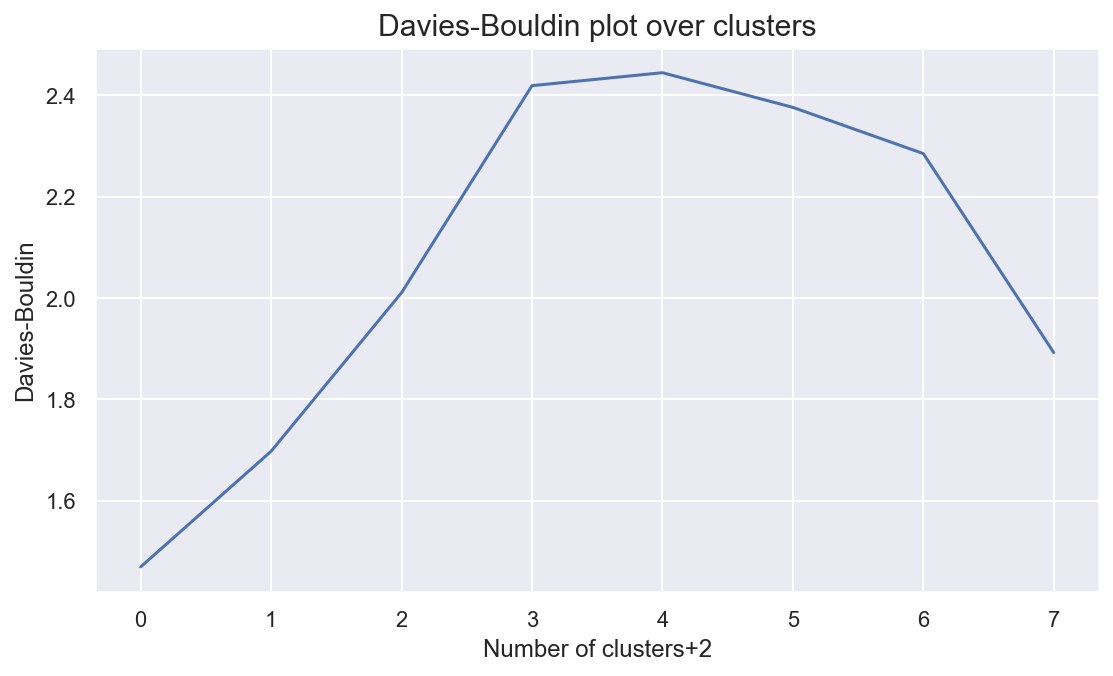

In [55]:
kmeans_elbows_plot(df_cluster_pref, 10)

#### We also ran the silhouette plot that shows a coefficient for the clusters’ quality depending on the number of clusters chosen. We applied in with some possible cluster numbers.

In [56]:
def complete_sh_score(data, k):
    # Storing average silhouette metric
    range_clusters = range(1, k)
    avg_silhouette = []
    for nclus in range_clusters:
        # Skip nclus == 1
        if nclus == 1:
            continue

        # Create a figure
        fig = plt.figure(figsize=(13, 7))

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")

        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])

        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(data) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

For n_clusters = 2, the average silhouette_score is : 0.4489179825726385
For n_clusters = 3, the average silhouette_score is : 0.293290276182219
For n_clusters = 4, the average silhouette_score is : 0.24714114596541326
For n_clusters = 5, the average silhouette_score is : 0.17064121020351836
For n_clusters = 6, the average silhouette_score is : 0.1051086950003879


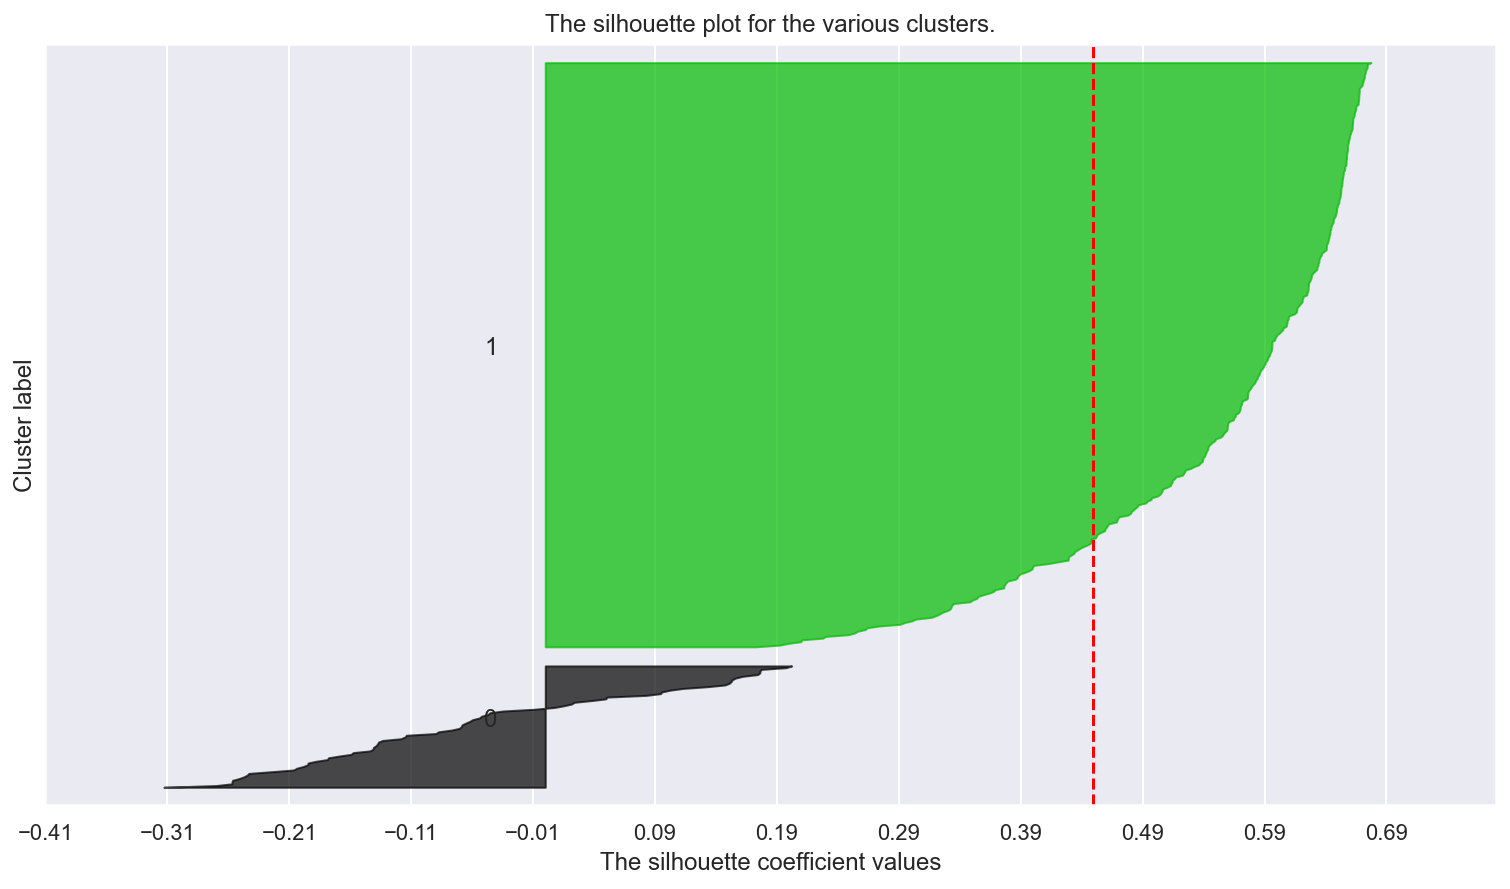

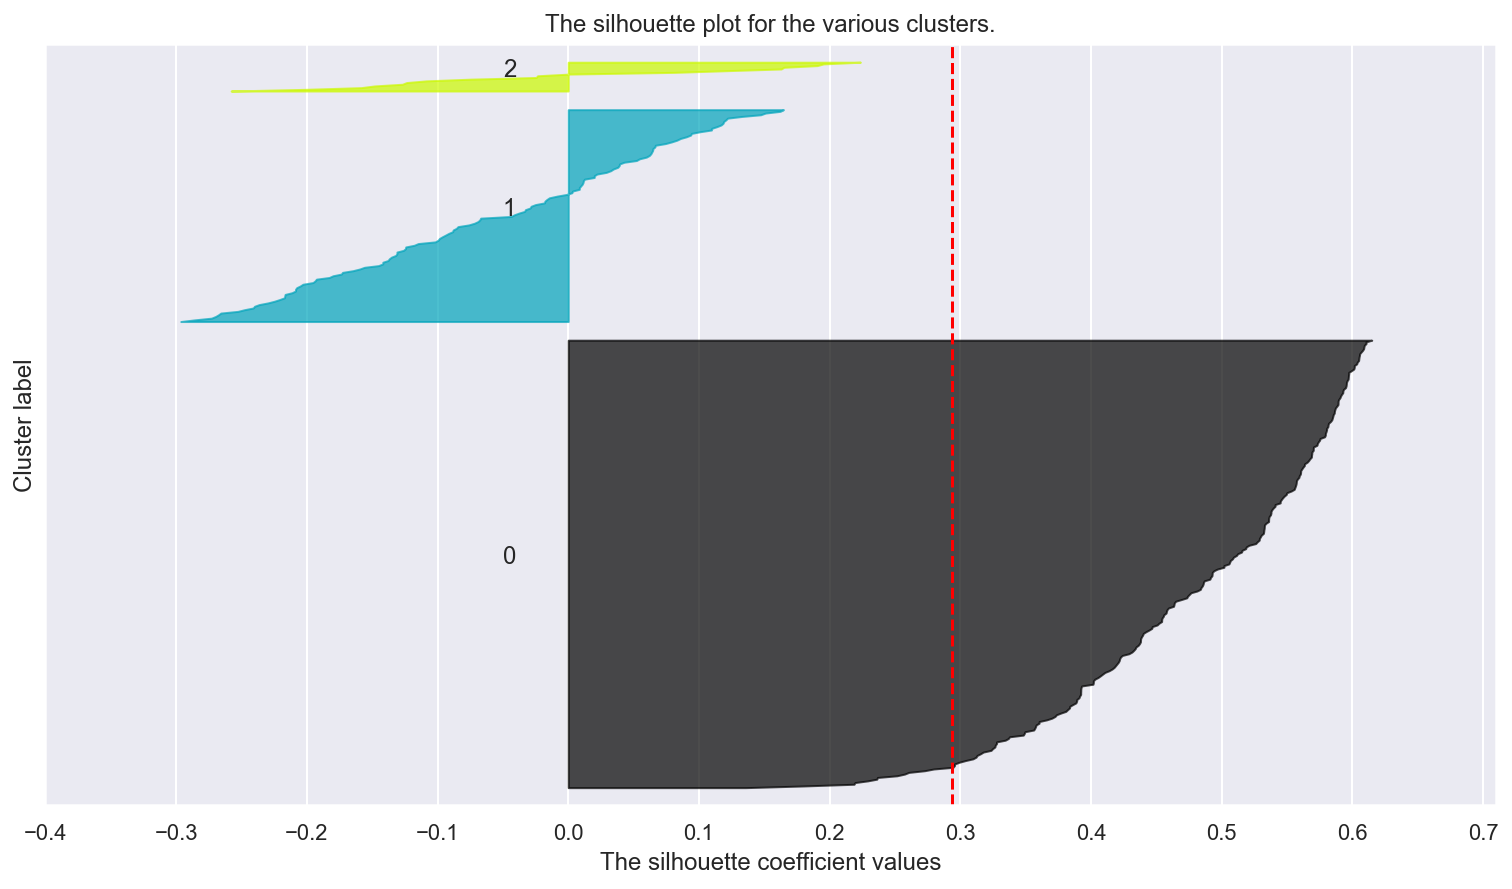

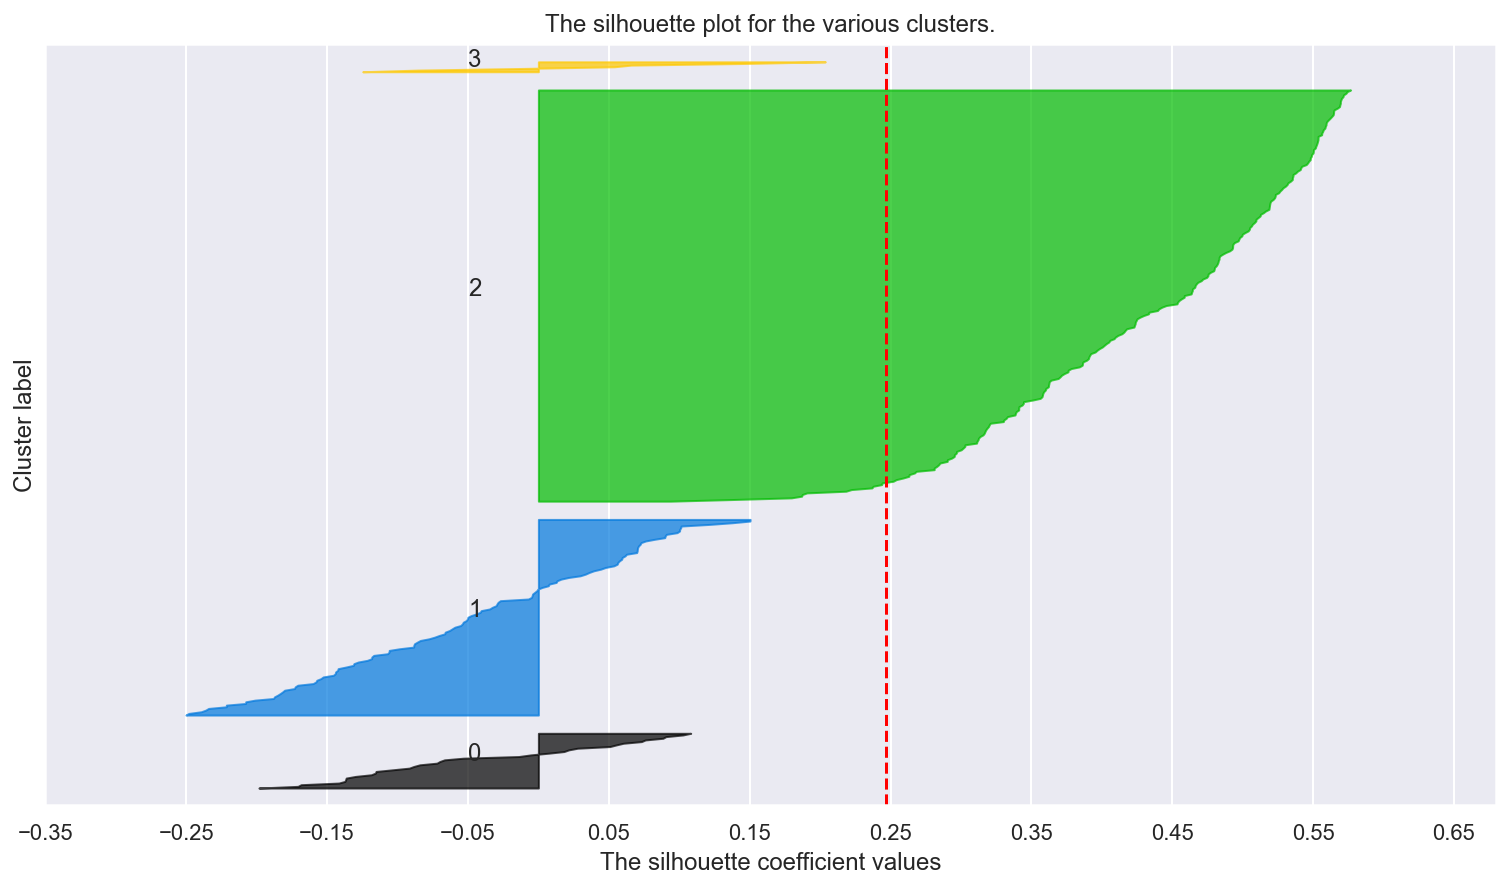

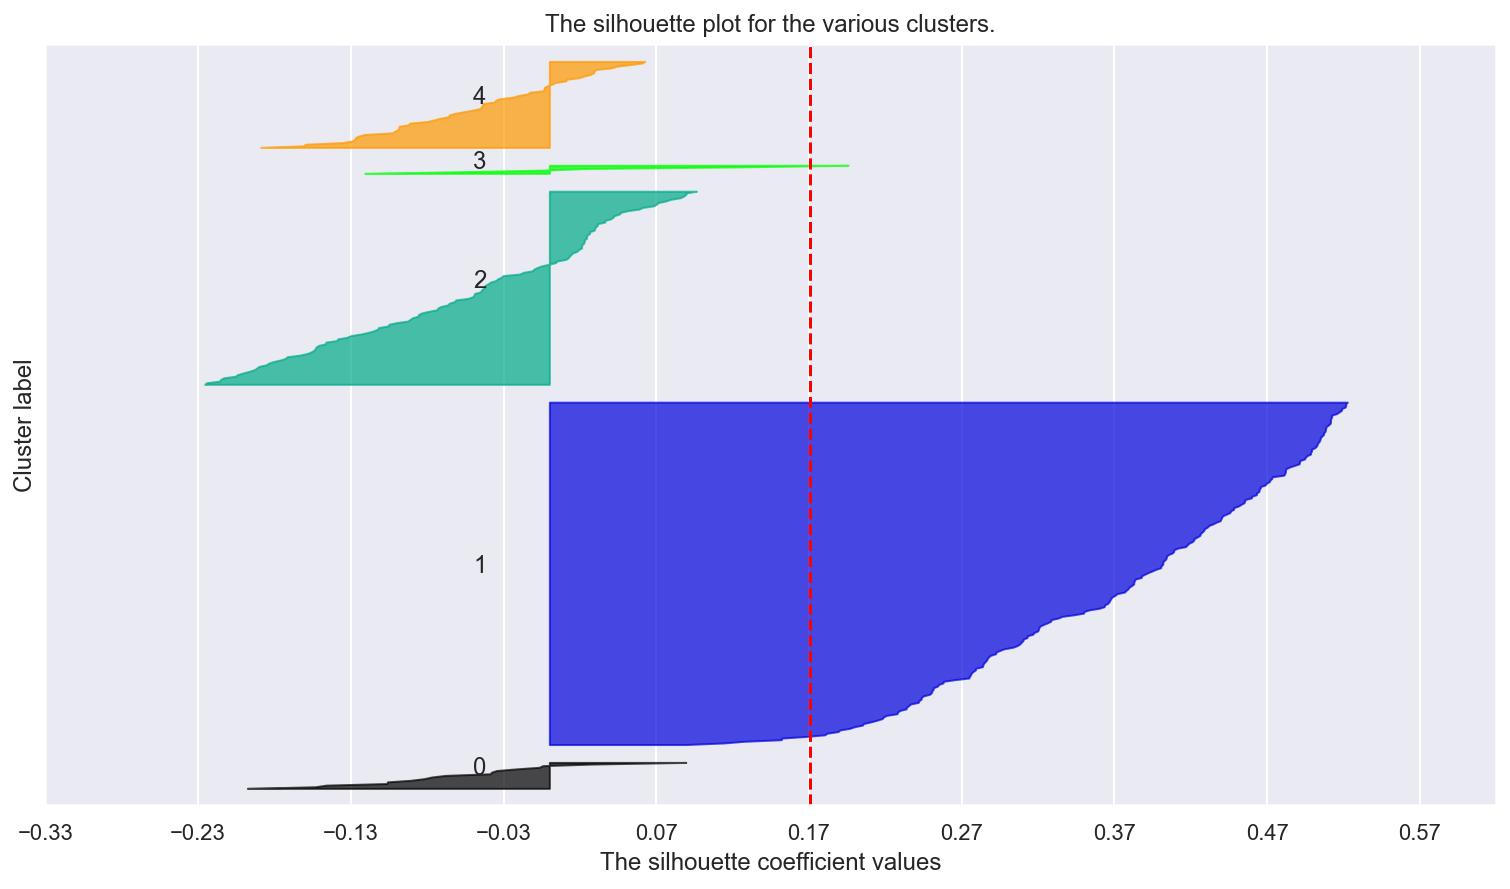

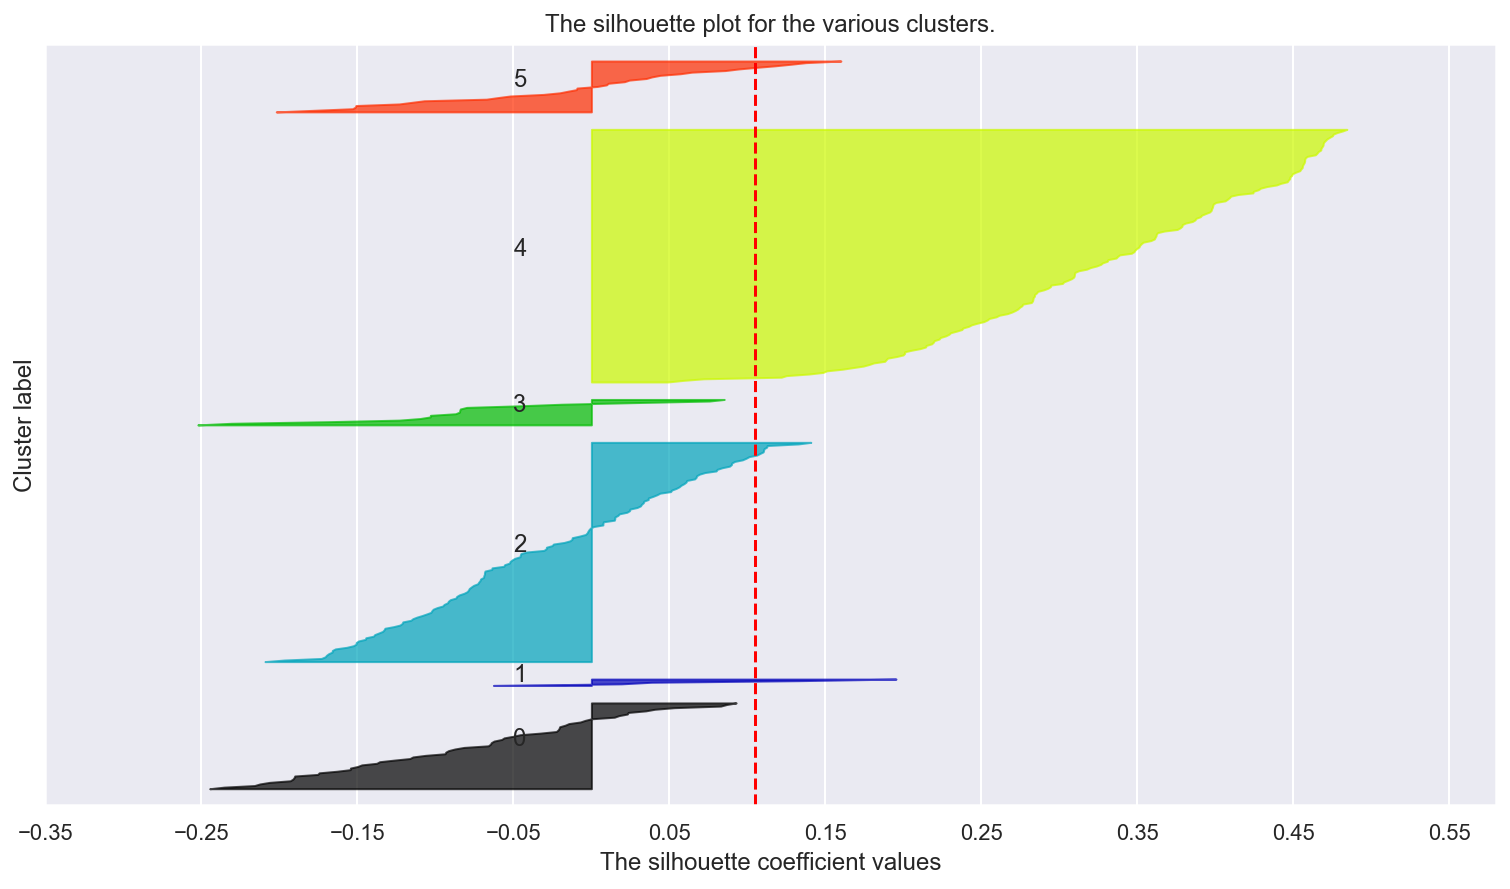

In [57]:
complete_sh_score(df_cluster_pref, 7)

#### After looking to the plots, we decided to proceed with 3 clusters

In [58]:
#We set the ‘k-means++’ as the initialization method (init parameter) 
#with 15 number of iterations to choose the best centroid in terms of inertia (n_init parameter).
kmeans_standard = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=15,
    random_state=1
)
kmeans_standard_labels = kmeans_standard.fit_predict(df_cluster_pref)

In [59]:
#Check the partion cluster
df_cluster_pref['kmeans_standard_labels'] = kmeans_standard_labels
df_cluster_pref.groupby('kmeans_standard_labels').count()

ProductCategory_ID,Category_1,Category_10,Category_100,Category_101,Category_102,Category_103,Category_104,Category_105,Category_106,Category_108,...,Category_9,Category_91,Category_92,Category_93,Category_94,Category_95,Category_96,Category_97,Category_98,Category_99
kmeans_standard_labels,,,,,,,,,,,,,,,,,,,,,
0,265,265,265,265,265,265,265,265,265,265,...,265,265,265,265,265,265,265,265,265,265
1,126,126,126,126,126,126,126,126,126,126,...,126,126,126,126,126,126,126,126,126,126
2,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18


## Evaluation

#### The R2 is a measure of the homogenity of a cluster solution. 

In [60]:
#Functions to get the R2.

def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable
def adjusted_r2(df, labels):
    """Return the overall adjusted R-squared"""
    
    # 1. calculate sst
    sst = get_ss(df)
    
    # 2. calculate ssw
    grouped_var = df.groupby(labels).var()
    grouped_count = df.groupby(labels).count() - 1
    ssw = np.sum(np.sum(grouped_var * grouped_count))
    
    # 3. return adjusted R-squared
    return 1 - ssw/sst

In [61]:
#R2 for k-means algorithm
adjusted_r2(df_cluster_pref,kmeans_standard_labels)

0.3617185113085948

#### Describe clusters - Visualizations

In [62]:
def cluster_profiles(df,label_columns, figsize, compar_titles=None, frequency = True):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    if frequency:
        fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    else:
        fig, axes = plt.subplots(nrows=len(label_columns), ncols=1, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        if frequency:    
            sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-90)
        if frequency:
            ax[1].set_xticklabels(cluster_labels)
            ax[1].set_xlabel("")
            ax[1].set_ylabel("Absolute Frequency")
            ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=10)
    plt.show()

In [63]:
df_cluster_pref

ProductCategory_ID,Category_1,Category_10,Category_100,Category_101,Category_102,Category_103,Category_104,Category_105,Category_106,Category_108,...,Category_91,Category_92,Category_93,Category_94,Category_95,Category_96,Category_97,Category_98,Category_99,kmeans_standard_labels
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
POS_1,0.922340,0.752500,0.110132,-0.410288,-0.771820,-0.167303,-0.219865,-0.571961,-0.480793,-0.519013,...,-0.453321,-0.322931,-0.658880,0.086455,-0.568530,-0.097967,0.415967,4.931514,-0.08374,1
POS_10,-0.398335,-0.470589,-0.621239,-0.567693,-0.771820,-0.167303,-0.219865,-0.571961,-0.480793,-0.550888,...,-0.729170,-0.573538,-0.658880,-0.753716,-0.455025,-0.836937,-0.729797,-0.310661,-0.08374,0
POS_100,0.778776,0.543896,0.411284,-0.063071,-0.110952,-0.167303,-0.219865,0.394867,-0.480793,0.830359,...,-0.003476,-0.320577,0.324631,-0.556459,-0.327332,-0.700091,-0.048532,1.686358,-0.08374,1
POS_101,-0.714058,-0.690091,1.013589,-0.257512,-0.331242,-0.167303,-0.219865,0.999135,-0.480793,-0.423389,...,-0.521222,-0.485296,-0.658880,-0.461483,-0.639470,-0.617983,-0.605931,-0.310661,-0.08374,0
POS_102,0.411226,-0.679712,0.712436,-0.294549,0.770204,-0.167303,1.077127,-0.491392,-0.480793,0.500985,...,0.565196,-0.272338,-0.494962,-0.176555,0.254380,-0.207444,0.942399,1.187103,-0.08374,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POS_94,-0.983912,-0.492383,0.798480,-0.252883,-0.331242,-0.167303,-0.219865,0.153160,-0.480793,-0.572138,...,-0.682488,-0.497062,-0.167125,-0.417648,-0.071946,-0.262183,-0.404648,-0.310661,-0.08374,0
POS_95,-0.211284,-0.386005,0.067110,-0.313067,0.770204,-0.167303,-0.219865,-0.491392,-0.373979,-0.380889,...,-0.304787,-0.174684,0.488549,-0.293448,-0.398273,0.394679,-0.373681,-0.310661,-0.08374,0
POS_97,-1.097096,-0.867042,-0.621239,-0.572323,-0.771820,-0.167303,-0.219865,-0.531677,-0.267165,-0.566826,...,-0.826777,-0.533535,-0.658880,-0.636823,-0.568530,-0.590614,-0.698831,0.188594,-0.08374,0


In [64]:
# Define metric features
metric_features = df_cluster_pref.columns

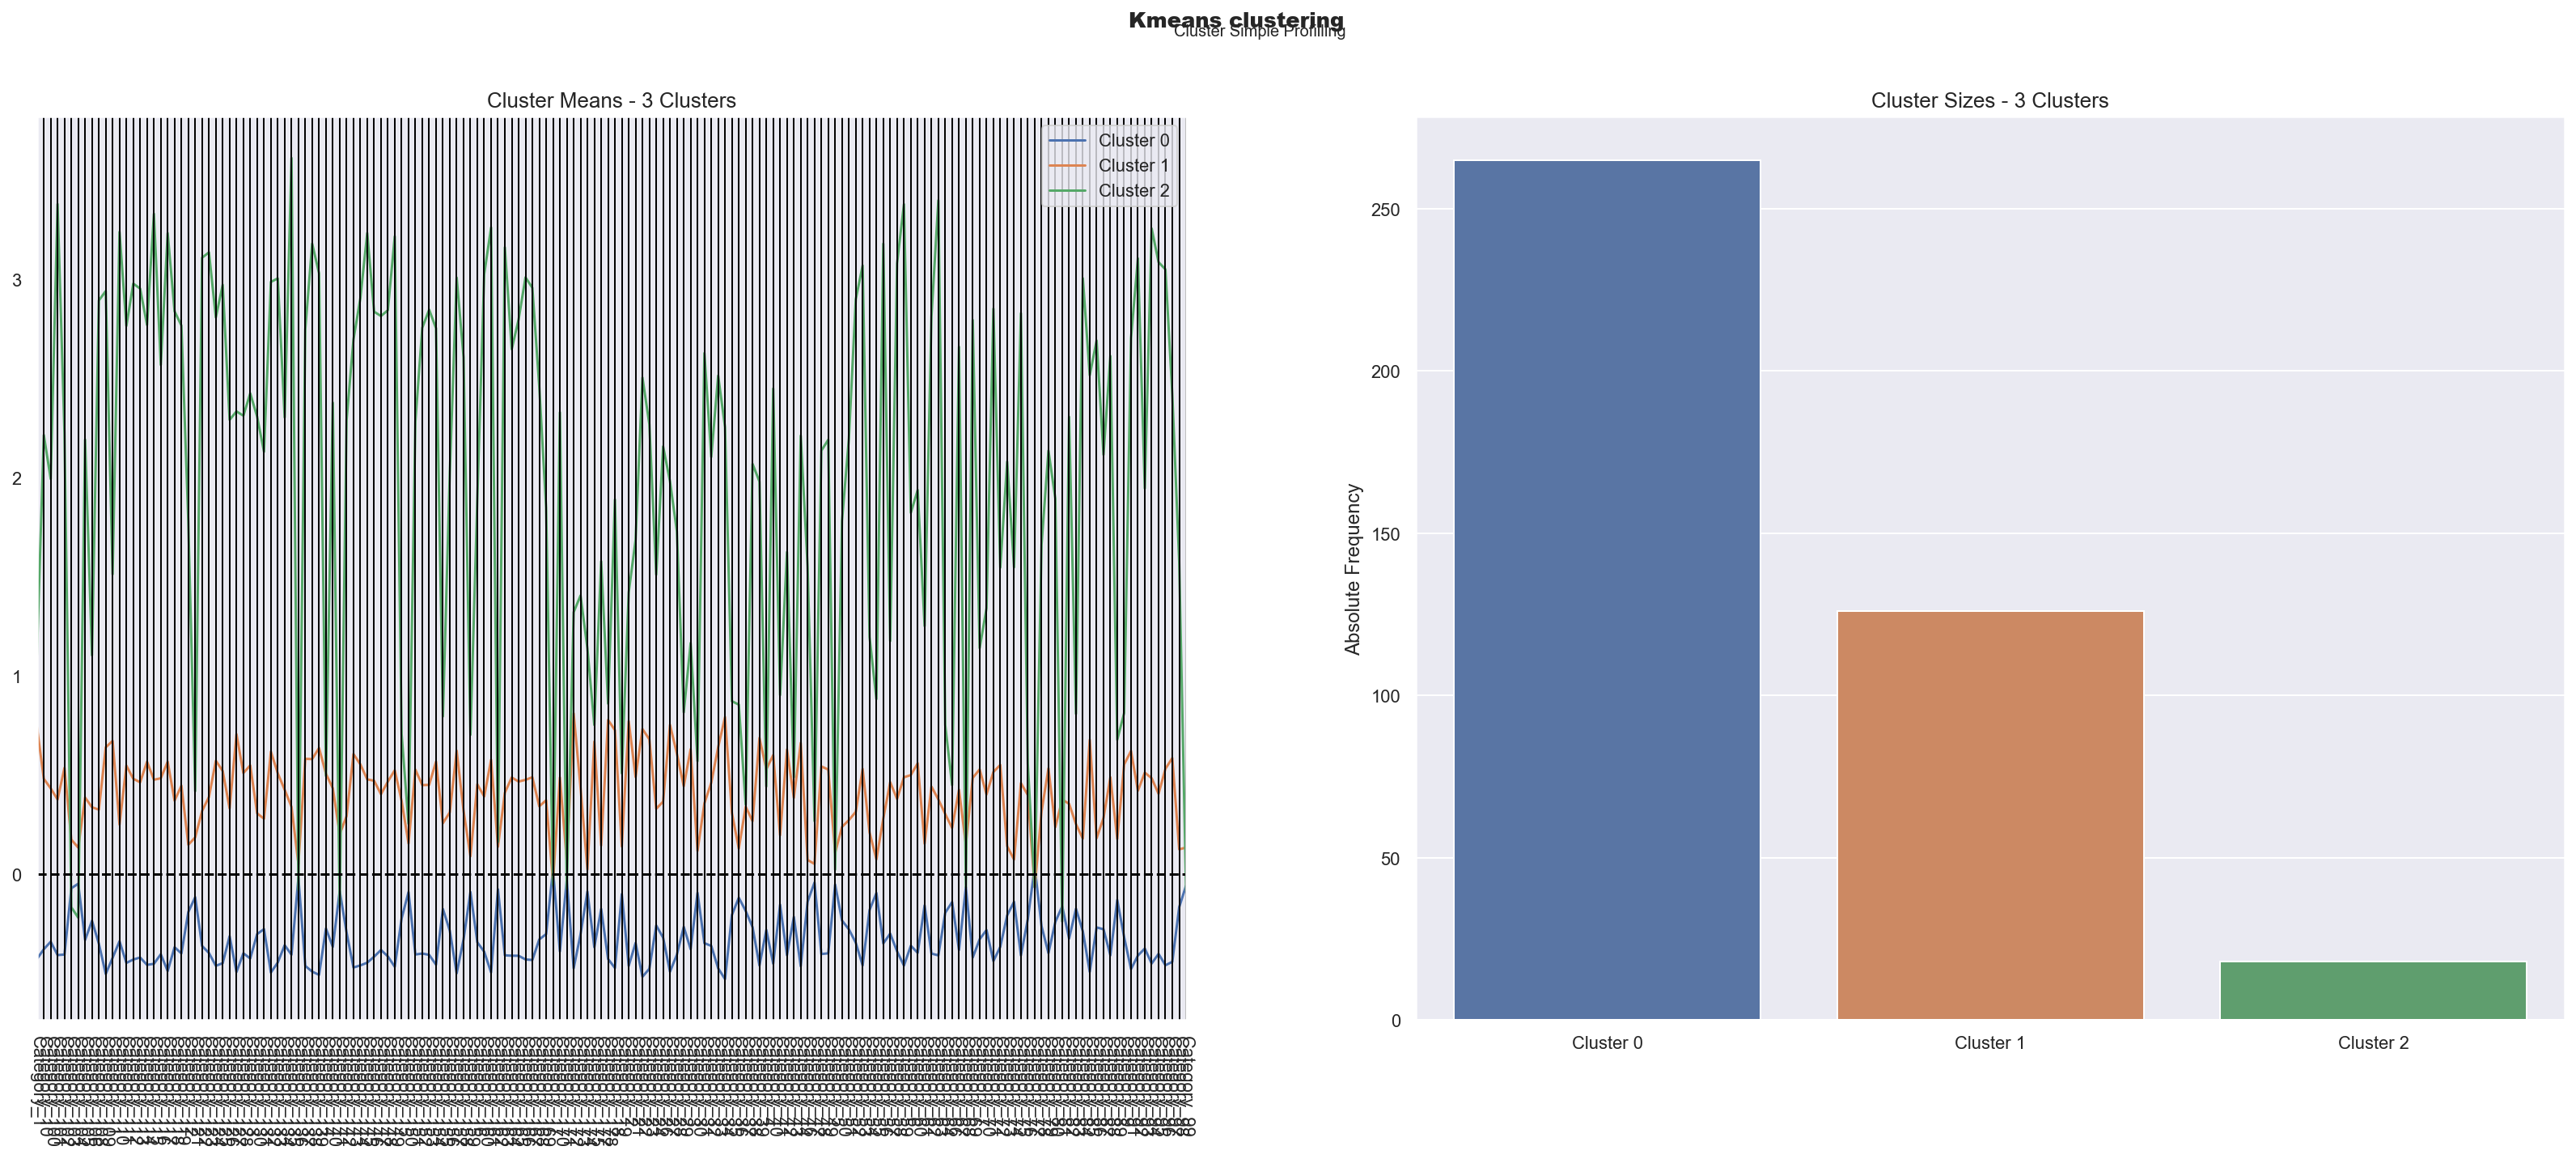

In [65]:
# Profilling cluster
cluster_profiles(
    df = df_cluster_pref,
    label_columns = ['kmeans_standard_labels'], 
    figsize = (28, 10), 
    compar_titles = ["Kmeans clustering"]
)

#### T-SNE (t-Distributed Stochastic Neighbor Embedding) is most used for multidimensional visualizations. It has many application but in this work , our objective is visualize clusters within the data and how a cluster solution fits them

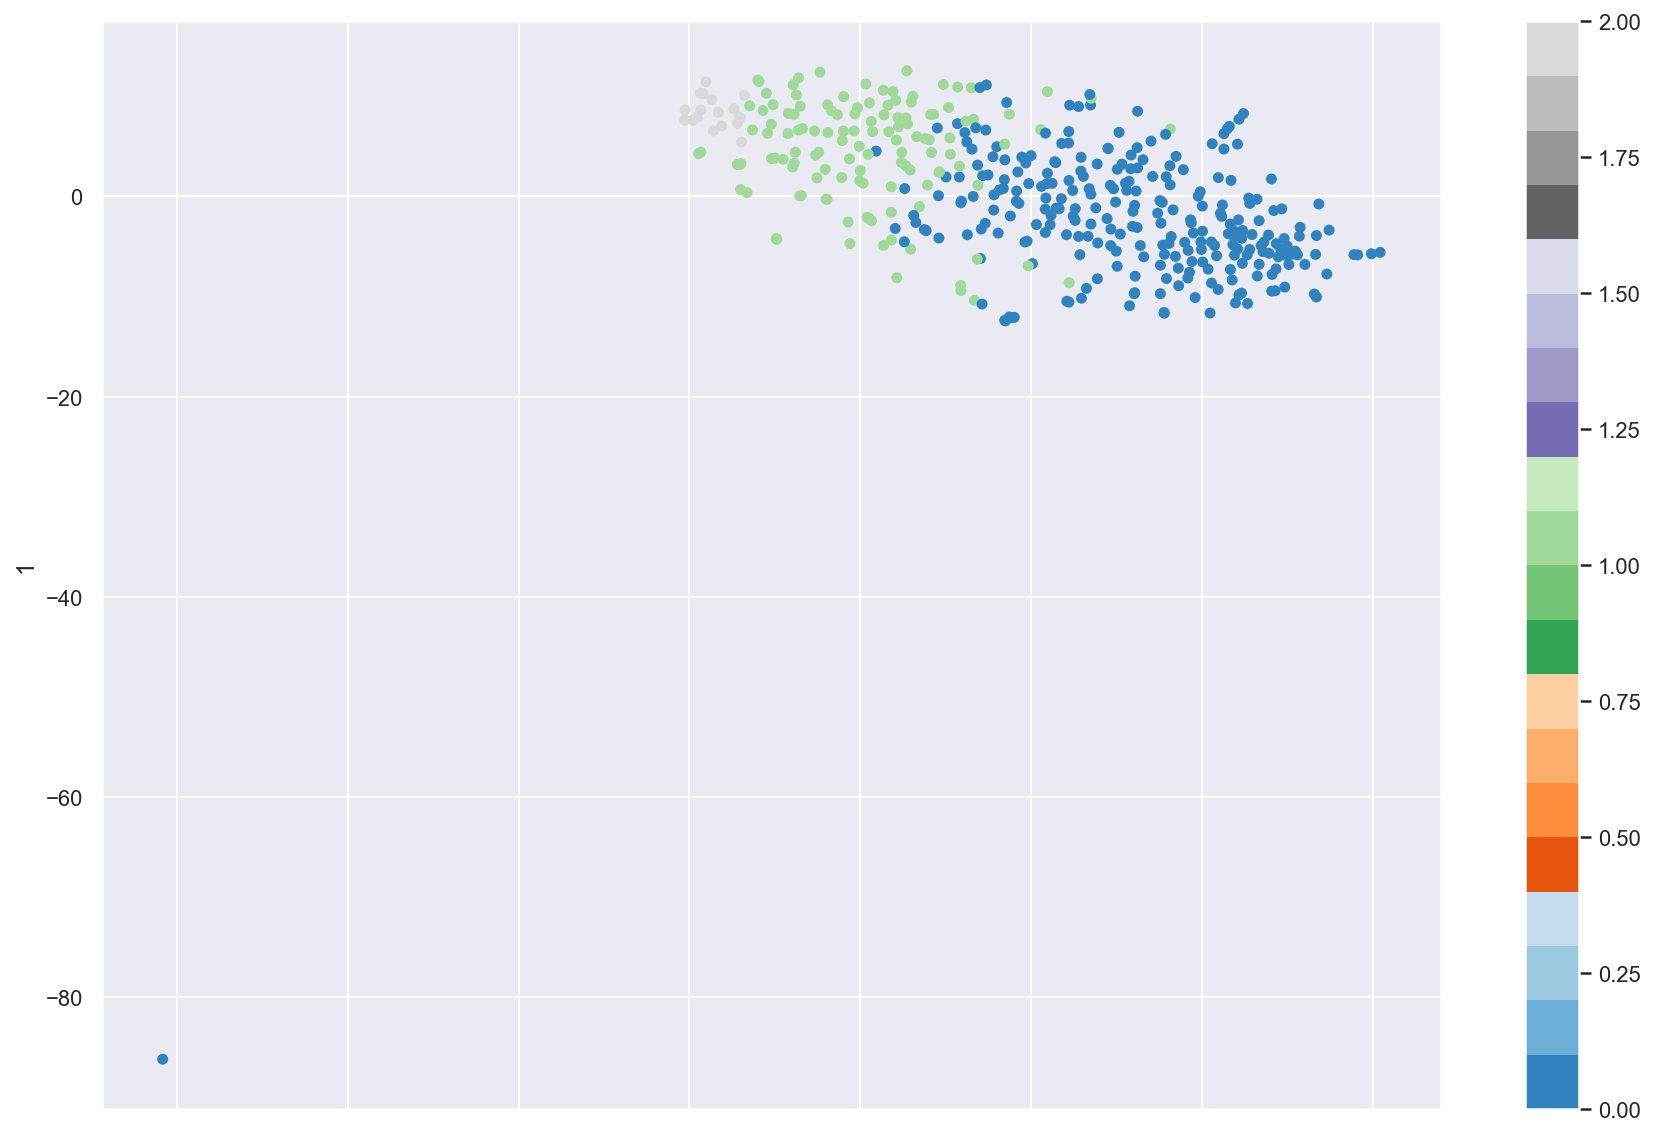

In [66]:
# Run the algorithm, fit and tranform the data
two_dim = TSNE(random_state=42).fit_transform( df_cluster_pref)
#Plot the data
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c= df_cluster_pref['kmeans_standard_labels'], colormap='tab20c', figsize=(15,10))
plt.show()

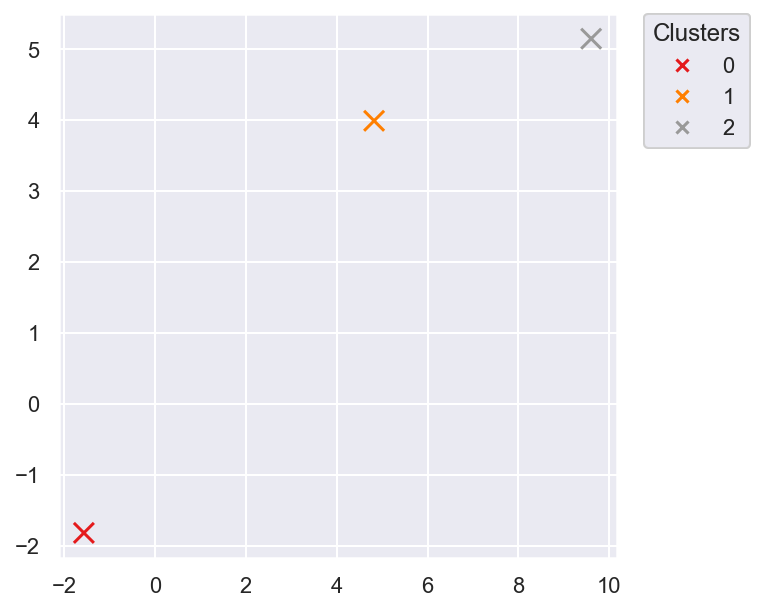

In [67]:
#Visualizing centroids with t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
#Run the algorithm, transform and fit the data
df_tsne = tsne.fit_transform( df_cluster_pref)
#Create a data frame to store the results of tnse
df_tsne = pd.DataFrame(df_tsne, index = df_cluster_pref.index)\
            .merge(df_cluster_pref['kmeans_standard_labels'], right_index = True, left_index = True)
#Store the centroids
centroids = df_tsne.groupby('kmeans_standard_labels').mean()
#Plot the data
fig, ax = plt.subplots(figsize = (5,5))
data = pd.DataFrame(centroids)
scatter = ax.scatter(x = data.iloc[:,0], y = data.iloc[:,1], c = range(3),marker = 'x', s = 100, cmap = 'Set1')
legend1 = ax.legend(*scatter.legend_elements(), title = 'Clusters', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.add_artist(legend1)
plt.show()

In [68]:
df_pref_cluster = df_pref.copy()

In [69]:
df_pref_cluster['kmeans_standard_labels']= df_cluster_pref['kmeans_standard_labels']

In [70]:
df_pref_cluster

,ProductCategory_ID,Quantity,kmeans_standard_labels
Point-of-Sale_ID,,,
POS_1,Category_1,4559.0,1
POS_1,Category_10,3912.0,1
POS_1,Category_100,17.0,1
POS_1,Category_101,45.0,1
POS_1,Category_108,12.0,1
...,...,...,...
POS_99,Category_93,3.0,0
POS_99,Category_94,107.0,0
POS_99,Category_95,8.0,0


In [71]:
df_pref_cluster.reset_index(inplace = True)

In [72]:
df_pref_cluster.rename(columns = {'kmeans_standard_labels':'Cluster_pref1'}, inplace = True)
df_pref_cluster

,Point-of-Sale_ID,ProductCategory_ID,Quantity,Cluster_pref1
0,POS_1,Category_1,4559.0,1
1,POS_1,Category_10,3912.0,1
2,POS_1,Category_100,17.0,1
3,POS_1,Category_101,45.0,1
4,POS_1,Category_108,12.0,1
...,...,...,...,...
52646,POS_99,Category_93,3.0,0
52647,POS_99,Category_94,107.0,0
52648,POS_99,Category_95,8.0,0
52649,POS_99,Category_96,29.0,0


In [73]:
df_pref_cluster1 = df_pref_cluster[['Point-of-Sale_ID', 'Cluster_pref1' ]]

In [74]:
df_pref_cluster1.drop_duplicates(inplace = True)

In [75]:
df_pref_cluster1.to_csv(os.path.join("dfcluster_pref1 .csv"), index=False)

In [76]:
df_pref_cluster1

,Point-of-Sale_ID,Cluster_pref1
0,POS_1,1
128,POS_10,0
231,POS_100,1
372,POS_101,0
508,POS_102,1
...,...,...
52007,POS_94,0
52133,POS_95,0
52269,POS_97,0
52395,POS_98,0


#### CLUSTER PREFERENCE BY PRODUCT FAMILY

In [77]:
df_pref_group_family = pd.DataFrame(df_merge.groupby(['Point-of-Sale_ID', 'ProductFamily_ID'])['Sales Values'].sum().unstack(fill_value=0))

In [78]:
df_pref_group_family = df_pref_group_family.reset_index()
df_pref_group_family 

ProductFamily_ID,Point-of-Sale_ID,Family_1,Family_10,Family_11,Family_12,Family_13,Family_14,Family_15,Family_16,Family_17,...,Family_2,Family_20,Family_21,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8,Family_9
0,POS_1,7.985411e+07,6.922791e+06,970378.0,1.042635e+08,2.685600e+06,2.167051e+07,3.026807e+07,6.667297e+06,377177.0,...,1.809318e+08,368610.0,9.195509e+07,5.049998e+07,360248.0,4.599321e+06,24687606.0,27031161.0,1.175238e+08,1.500939e+08
1,POS_10,3.604888e+07,1.775854e+06,516182.0,3.959389e+07,5.279020e+05,7.252342e+06,1.069497e+07,2.547492e+06,13017.0,...,9.319093e+07,135030.0,2.633170e+07,2.238890e+07,206692.0,2.804685e+06,11784595.0,17793135.0,6.426569e+07,6.257000e+07
2,POS_100,1.238134e+08,4.850180e+06,1639898.0,1.218879e+08,2.758017e+06,2.851055e+07,3.335303e+07,7.055497e+06,608377.0,...,2.597188e+08,935947.0,1.005388e+08,6.580899e+07,714587.0,8.029739e+06,43501720.0,22266147.0,1.637687e+08,2.395011e+08
3,POS_101,5.817832e+07,1.977409e+06,490175.0,5.311268e+07,1.459187e+06,1.603529e+07,1.786869e+07,3.329246e+06,127290.0,...,1.141058e+08,822574.0,5.400484e+07,3.490578e+07,199444.0,2.765233e+06,14011751.0,7597015.0,7.383551e+07,9.555321e+07
4,POS_102,1.069806e+08,4.692052e+06,907567.0,1.337736e+08,1.654209e+06,2.281303e+07,2.888446e+07,6.586352e+06,1032975.5,...,2.461599e+08,1407816.0,8.580846e+07,7.690030e+07,544481.0,4.039382e+06,32624438.0,35198552.0,1.187422e+08,1.699707e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,POS_94,2.876163e+07,2.634251e+06,316164.0,4.987799e+07,9.240000e+05,8.297228e+06,9.621151e+06,2.023673e+06,76539.0,...,5.599859e+07,300028.0,4.120571e+07,9.824972e+06,246295.0,1.353024e+06,8067154.0,9442118.0,2.587195e+07,5.031382e+07
405,POS_95,5.352426e+07,4.308528e+06,481096.0,7.791204e+07,1.567232e+06,1.787117e+07,1.666822e+07,4.261973e+06,186860.0,...,1.243194e+08,405820.0,6.569372e+07,2.348882e+07,332471.0,2.642220e+06,13654228.0,21238469.0,5.026069e+07,9.183613e+07
406,POS_97,3.247578e+07,2.097841e+06,462641.0,4.674194e+07,7.508370e+05,9.113698e+06,9.551421e+06,2.220751e+06,100963.0,...,7.980067e+07,139858.0,2.394006e+07,1.543362e+07,125231.0,1.871365e+06,10105010.0,10950856.0,3.063473e+07,5.655495e+07
407,POS_98,4.887512e+07,1.546995e+06,886657.0,4.128297e+07,8.340120e+05,9.520150e+06,1.533651e+07,3.473752e+06,121411.0,...,1.080505e+08,118362.0,3.615059e+07,3.298044e+07,289069.0,2.853883e+06,12305985.0,13791591.0,9.108389e+07,1.019013e+08


In [79]:
df_pref_group_family.set_index('Point-of-Sale_ID',inplace = True)
df_pref_group_family

ProductFamily_ID,Family_1,Family_10,Family_11,Family_12,Family_13,Family_14,Family_15,Family_16,Family_17,Family_18,...,Family_2,Family_20,Family_21,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8,Family_9
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
POS_1,7.985411e+07,6.922791e+06,970378.0,1.042635e+08,2.685600e+06,2.167051e+07,3.026807e+07,6.667297e+06,377177.0,6.911406e+07,...,1.809318e+08,368610.0,9.195509e+07,5.049998e+07,360248.0,4.599321e+06,24687606.0,27031161.0,1.175238e+08,1.500939e+08
POS_10,3.604888e+07,1.775854e+06,516182.0,3.959389e+07,5.279020e+05,7.252342e+06,1.069497e+07,2.547492e+06,13017.0,2.243292e+07,...,9.319093e+07,135030.0,2.633170e+07,2.238890e+07,206692.0,2.804685e+06,11784595.0,17793135.0,6.426569e+07,6.257000e+07
POS_100,1.238134e+08,4.850180e+06,1639898.0,1.218879e+08,2.758017e+06,2.851055e+07,3.335303e+07,7.055497e+06,608377.0,6.961182e+07,...,2.597188e+08,935947.0,1.005388e+08,6.580899e+07,714587.0,8.029739e+06,43501720.0,22266147.0,1.637687e+08,2.395011e+08
POS_101,5.817832e+07,1.977409e+06,490175.0,5.311268e+07,1.459187e+06,1.603529e+07,1.786869e+07,3.329246e+06,127290.0,2.991138e+07,...,1.141058e+08,822574.0,5.400484e+07,3.490578e+07,199444.0,2.765233e+06,14011751.0,7597015.0,7.383551e+07,9.555321e+07
POS_102,1.069806e+08,4.692052e+06,907567.0,1.337736e+08,1.654209e+06,2.281303e+07,2.888446e+07,6.586352e+06,1032975.5,5.753802e+07,...,2.461599e+08,1407816.0,8.580846e+07,7.690030e+07,544481.0,4.039382e+06,32624438.0,35198552.0,1.187422e+08,1.699707e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POS_94,2.876163e+07,2.634251e+06,316164.0,4.987799e+07,9.240000e+05,8.297228e+06,9.621151e+06,2.023673e+06,76539.0,1.789935e+07,...,5.599859e+07,300028.0,4.120571e+07,9.824972e+06,246295.0,1.353024e+06,8067154.0,9442118.0,2.587195e+07,5.031382e+07
POS_95,5.352426e+07,4.308528e+06,481096.0,7.791204e+07,1.567232e+06,1.787117e+07,1.666822e+07,4.261973e+06,186860.0,3.272847e+07,...,1.243194e+08,405820.0,6.569372e+07,2.348882e+07,332471.0,2.642220e+06,13654228.0,21238469.0,5.026069e+07,9.183613e+07
POS_97,3.247578e+07,2.097841e+06,462641.0,4.674194e+07,7.508370e+05,9.113698e+06,9.551421e+06,2.220751e+06,100963.0,2.604688e+07,...,7.980067e+07,139858.0,2.394006e+07,1.543362e+07,125231.0,1.871365e+06,10105010.0,10950856.0,3.063473e+07,5.655495e+07


In [80]:
#Create a copy
df_standard=df_pref_group_family.copy()

In [81]:
#Select data
features = df_standard.columns
# Create a StandardScaler
scale = StandardScaler()
# Fit and Transform data by applying the scale obtained in the previous command
scale_feat= scale.fit_transform(df_standard[features])
#Applying the transformation in the dataset
df_standard[features]=scale_feat
#Check the results
df_standard.head()

ProductFamily_ID,Family_1,Family_10,Family_11,Family_12,Family_13,Family_14,Family_15,Family_16,Family_17,Family_18,...,Family_2,Family_20,Family_21,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8,Family_9
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
POS_1,0.526116,0.784283,-0.380682,0.209723,0.964118,0.170124,0.913177,0.524711,-0.129895,0.857138,...,0.441001,-0.595420,0.116855,1.234166,0.133179,1.163476,0.435751,0.230051,0.763936,0.768246
POS_10,-0.959524,-1.043461,-0.640843,-1.260771,-1.123685,-1.217099,-1.083074,-0.895085,-0.992209,-1.091011,...,-0.825557,-0.691200,-0.809080,-0.428411,-0.605708,-0.030085,-0.721902,-0.463945,-0.591107,-0.988699
POS_100,2.016982,0.048272,0.002814,0.610477,1.034189,0.828228,1.227810,0.658495,0.417577,0.877911,...,1.578309,-0.362783,0.237968,2.139588,1.838202,3.444948,2.123745,-0.127915,1.940544,2.562998
POS_101,-0.209012,-0.971886,-0.655740,-0.953373,-0.222568,-0.372060,-0.351430,-0.625671,-0.721616,-0.778911,...,-0.523647,-0.409272,-0.418617,0.311876,-0.640584,-0.056324,-0.522082,-1.229918,-0.347623,-0.326597
POS_102,1.446103,-0.007882,-0.416660,0.880742,-0.033863,0.280050,0.772063,0.496815,1.423007,0.374034,...,1.382584,-0.169293,0.030127,2.795563,1.019679,0.791076,1.147840,0.843618,0.794935,1.167252


In [82]:
#Check the statistics summary
df_standard.describe().apply(lambda s: s.apply(lambda x:format(x,'g')))

ProductFamily_ID,Family_1,Family_10,Family_11,Family_12,Family_13,Family_14,Family_15,Family_16,Family_17,Family_18,...,Family_2,Family_20,Family_21,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8,Family_9
count,409,409,409,409,409,409,409,409,409,409,...,409,409,409,409,409,409,409,409,409,409
mean,-2.02229e-17,2.87735e-17,-8.30631e-17,-4.81278e-16,9.13423e-17,6.3451e-18,-1.09801e-16,2.49732e-17,4.69605e-17,8.57776e-17,...,-3.58312e-17,-1.68026e-16,5.22538e-17,-1.82413e-16,2.45661e-16,-9.71784e-17,2.81627e-18,-1.39321e-16,-1.54183e-16,-2.12815e-16
std,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,...,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122,1.00122
min,-1.75054,-1.48799,-0.909043,-1.73064,-1.45145,-1.56605,-1.66439,-1.57637,-1.01261,-1.64507,...,-1.84254,-0.730026,-1.1131,-1.52907,-1.46301,-1.62781,-1.61245,-1.62582,-1.7593,-1.75903
25%,-0.708471,-0.737637,-0.599094,-0.727502,-0.701129,-0.742683,-0.732276,-0.728282,-0.638219,-0.766861,...,-0.735432,-0.604743,-0.615588,-0.762558,-0.668387,-0.738753,-0.729107,-0.6771,-0.746936,-0.721405
50%,-0.225614,-0.145409,-0.310031,-0.173721,-0.194908,-0.152778,-0.170556,-0.167278,-0.299417,-0.195466,...,-0.153151,-0.362783,-0.294834,-0.198876,-0.180101,-0.22584,-0.243173,-0.205326,-0.176954,-0.199167
75%,0.550352,0.494891,0.232501,0.610969,0.390274,0.447407,0.590563,0.495303,0.245836,0.559198,...,0.623334,0.154549,0.300112,0.521668,0.427726,0.533507,0.535956,0.42777,0.599522,0.589633
max,4.73451,7.23881,6.72093,4.74283,5.2092,5.57401,4.39296,5.11736,6.63968,4.03784,...,3.85049,6.55037,6.56914,4.29194,7.94076,3.44495,4.24456,4.79112,3.42513,4.14089


In [83]:
#Create a copy only with metric features to run the cluster.
#To run the clustering solutions, we selected only numerical features. 
df_cluster_pref_family = df_standard.copy()

In [84]:
def kmeans_elbows_plot(data, k):

    K = range(2, k) 

    inertia = []
    avg_silhouette = []
    db_scores =[]
    for k in K:
        kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=1)
        kmeanModel.fit(data)
        clusters = kmeanModel.labels_
        inertia.append(kmeanModel.inertia_)
        avg_silhouette.append(silhouette_score(data, clusters))
        db_scores.append(davies_bouldin_score(data, clusters))

    # The inertia plot
    plt.figure(figsize=(9,5))
    plt.plot(inertia)
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters+2")
    plt.title("Inertia plot over clusters", size=15)
    plt.show()

    # The average silhouette plot
    plt.figure(figsize=(9,5))
    plt.plot(avg_silhouette)
    plt.ylabel("Average silhouette")
    plt.xlabel("Number of clusters+2")
    plt.title("Average silhouette plot over clusters", size=15)
    plt.show()

    # The Davies Bouldin score
    plt.figure(figsize=(9,5))
    plt.plot(db_scores)
    plt.ylabel("Davies-Bouldin")
    plt.xlabel("Number of clusters+2")
    plt.title("Davies-Bouldin plot over clusters", size=15)
    plt.show()

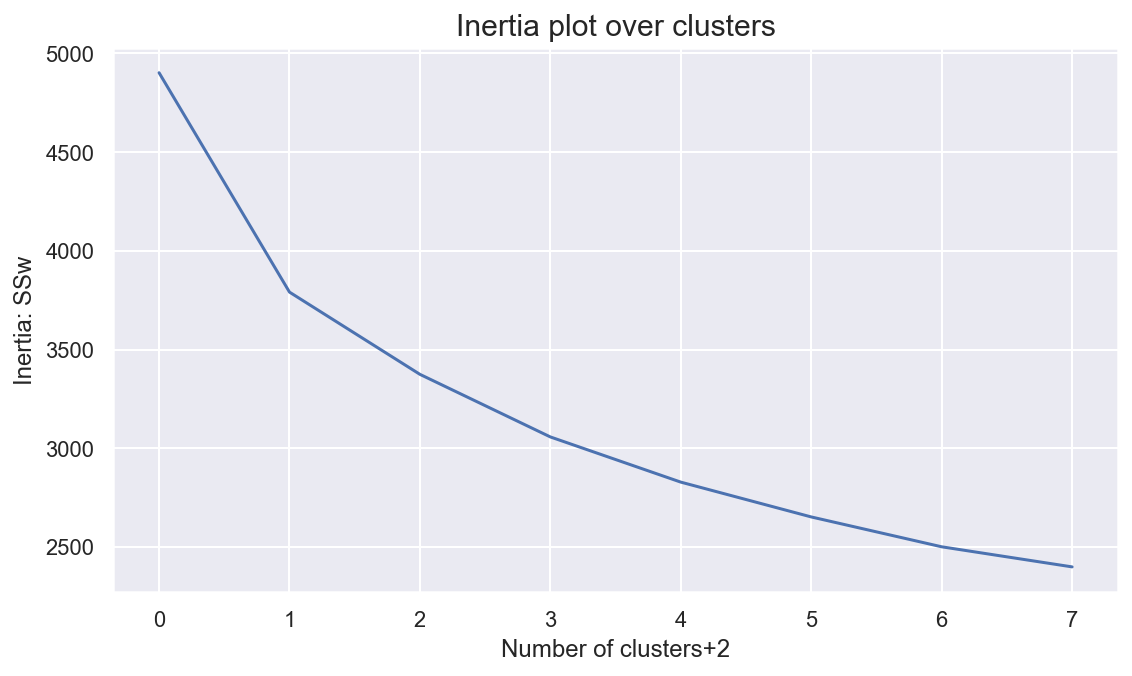

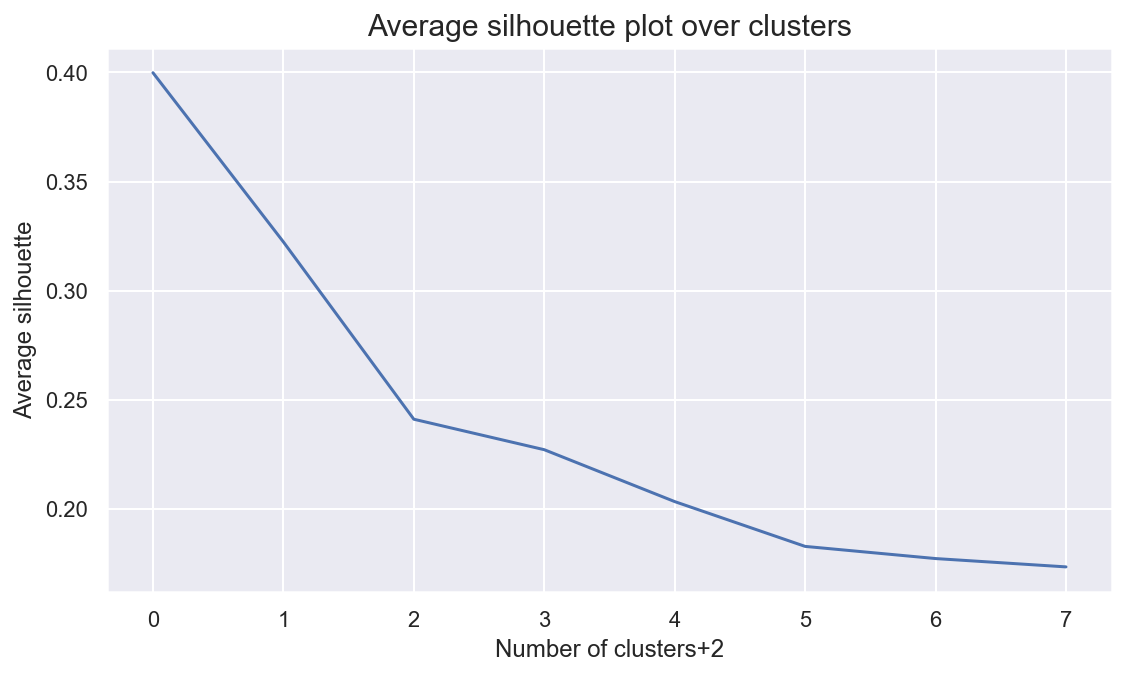

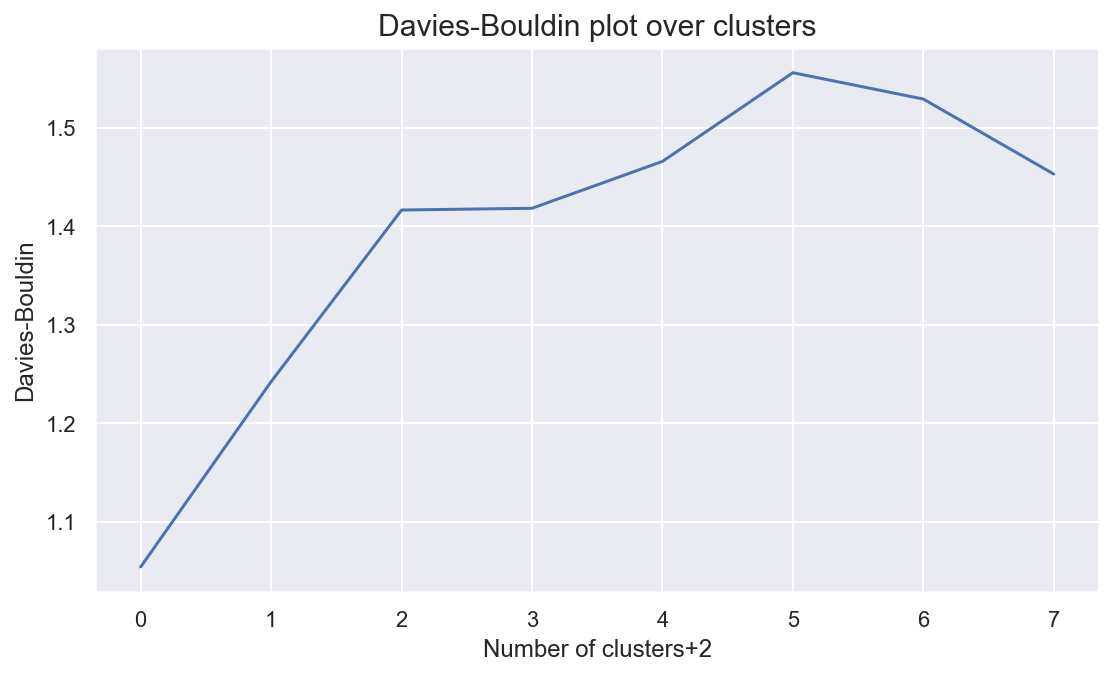

In [85]:
kmeans_elbows_plot(df_cluster_pref_family, 10)

#### We also ran the silhouette plot that shows a coefficient for the clusters’ quality depending on the number of clusters chosen. We applied in with some possible cluster numbers.

In [86]:
def complete_sh_score(data, k):
    # Storing average silhouette metric
    range_clusters = range(1, k)
    avg_silhouette = []
    for nclus in range_clusters:
        # Skip nclus == 1
        if nclus == 1:
            continue

        # Create a figure
        fig = plt.figure(figsize=(13, 7))

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")

        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])

        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(data) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

For n_clusters = 2, the average silhouette_score is : 0.39986804910665297
For n_clusters = 3, the average silhouette_score is : 0.322382249402394
For n_clusters = 4, the average silhouette_score is : 0.24115536441414184
For n_clusters = 5, the average silhouette_score is : 0.22719460601625543
For n_clusters = 6, the average silhouette_score is : 0.20342924967340734


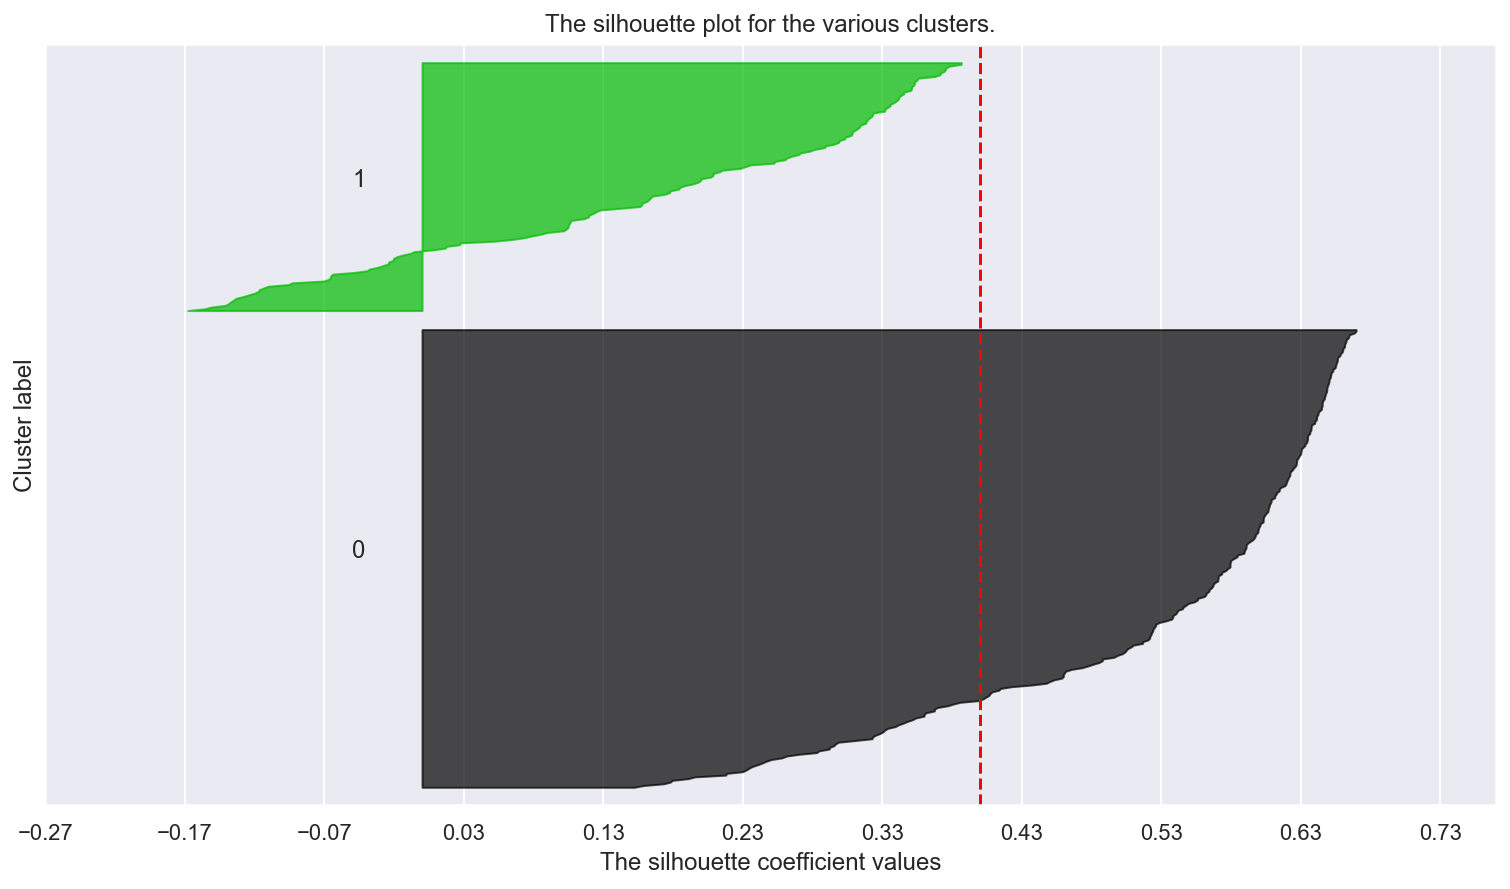

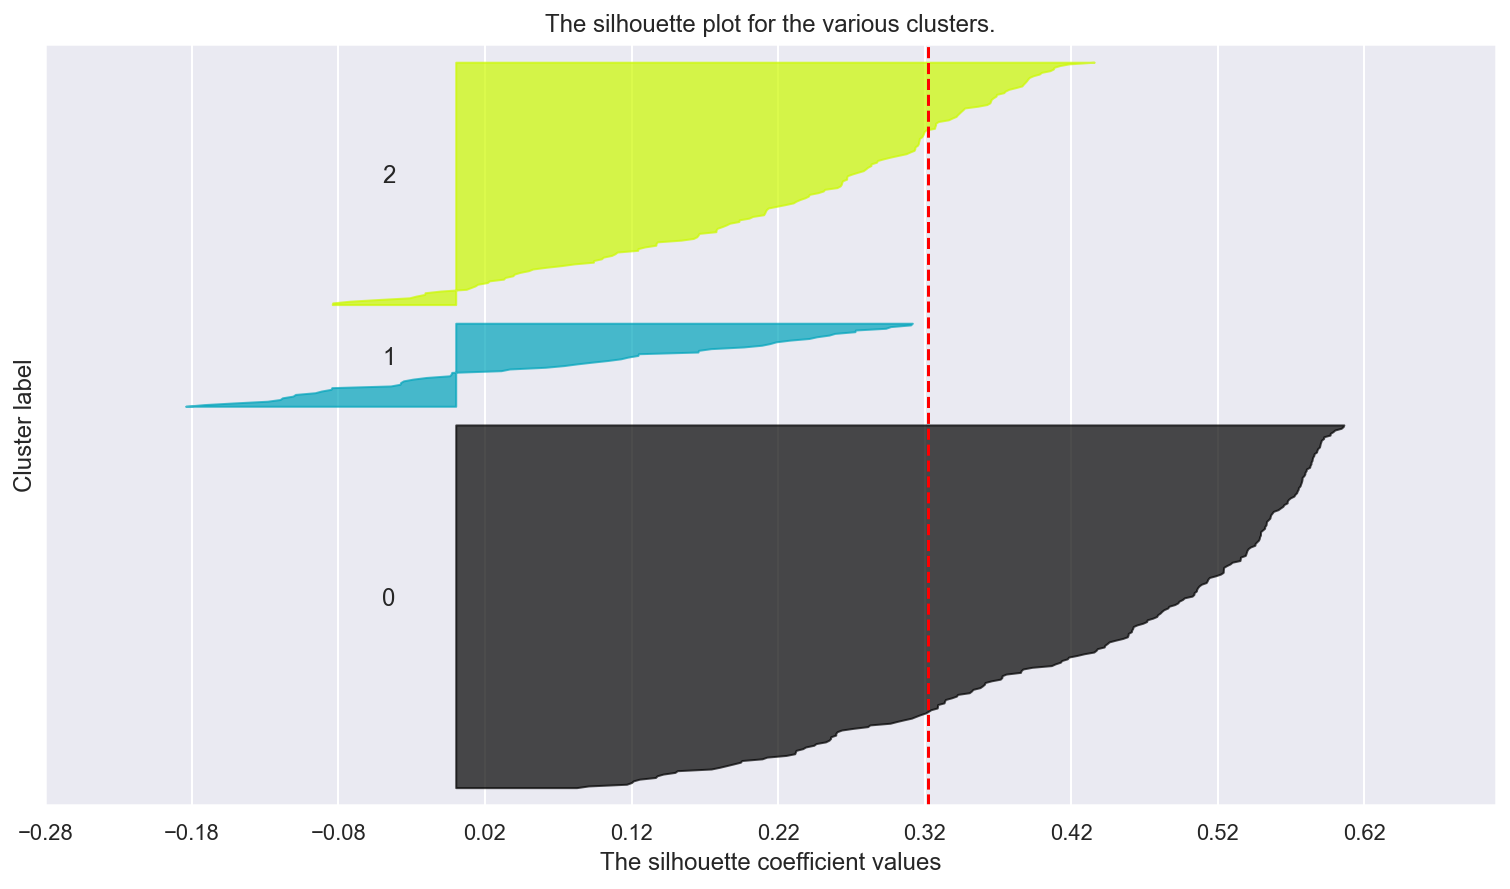

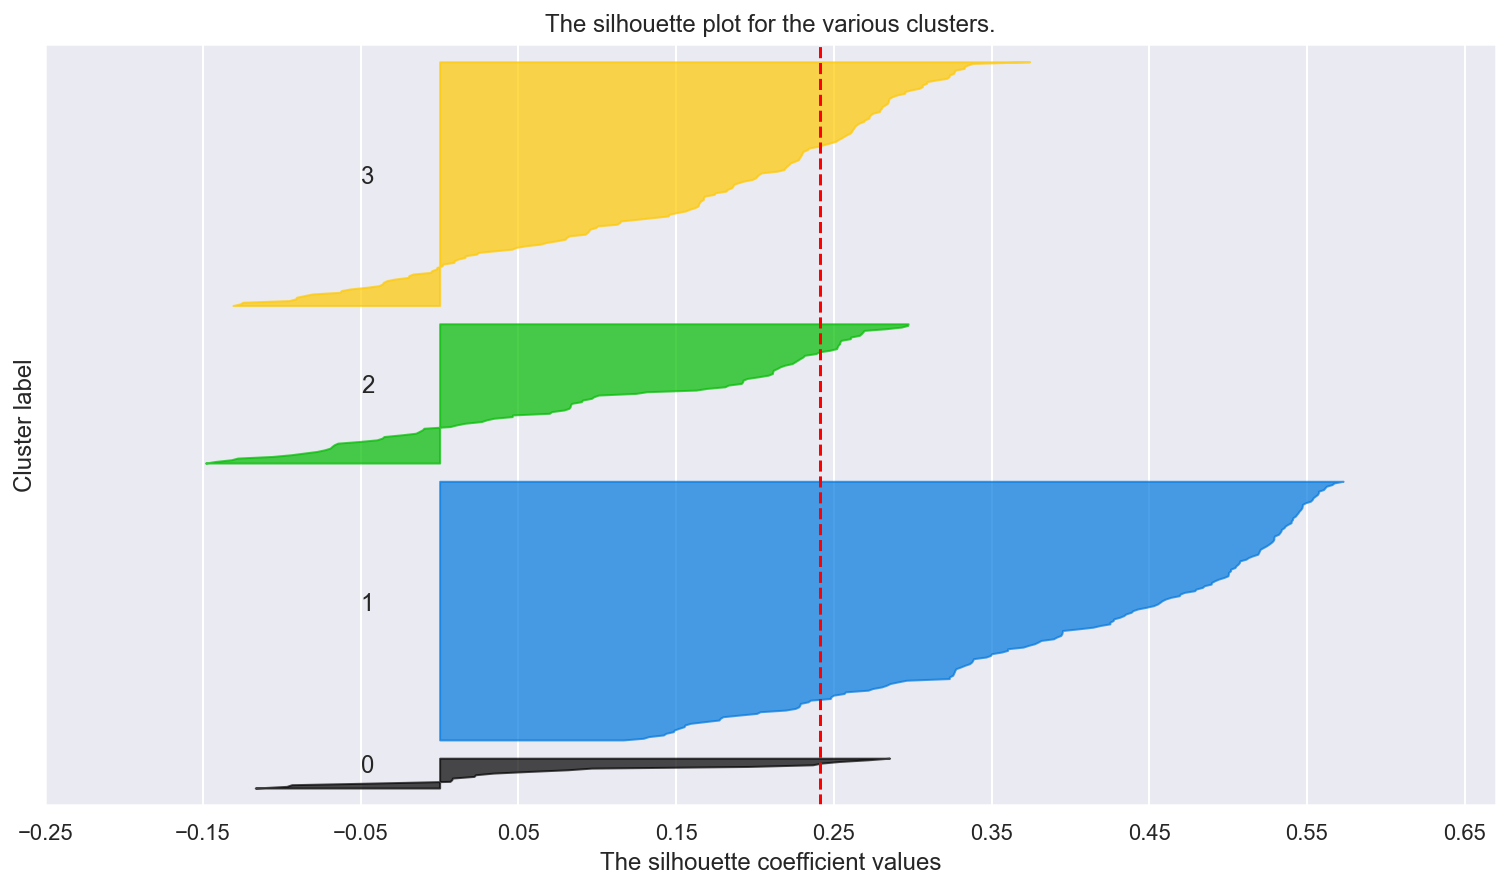

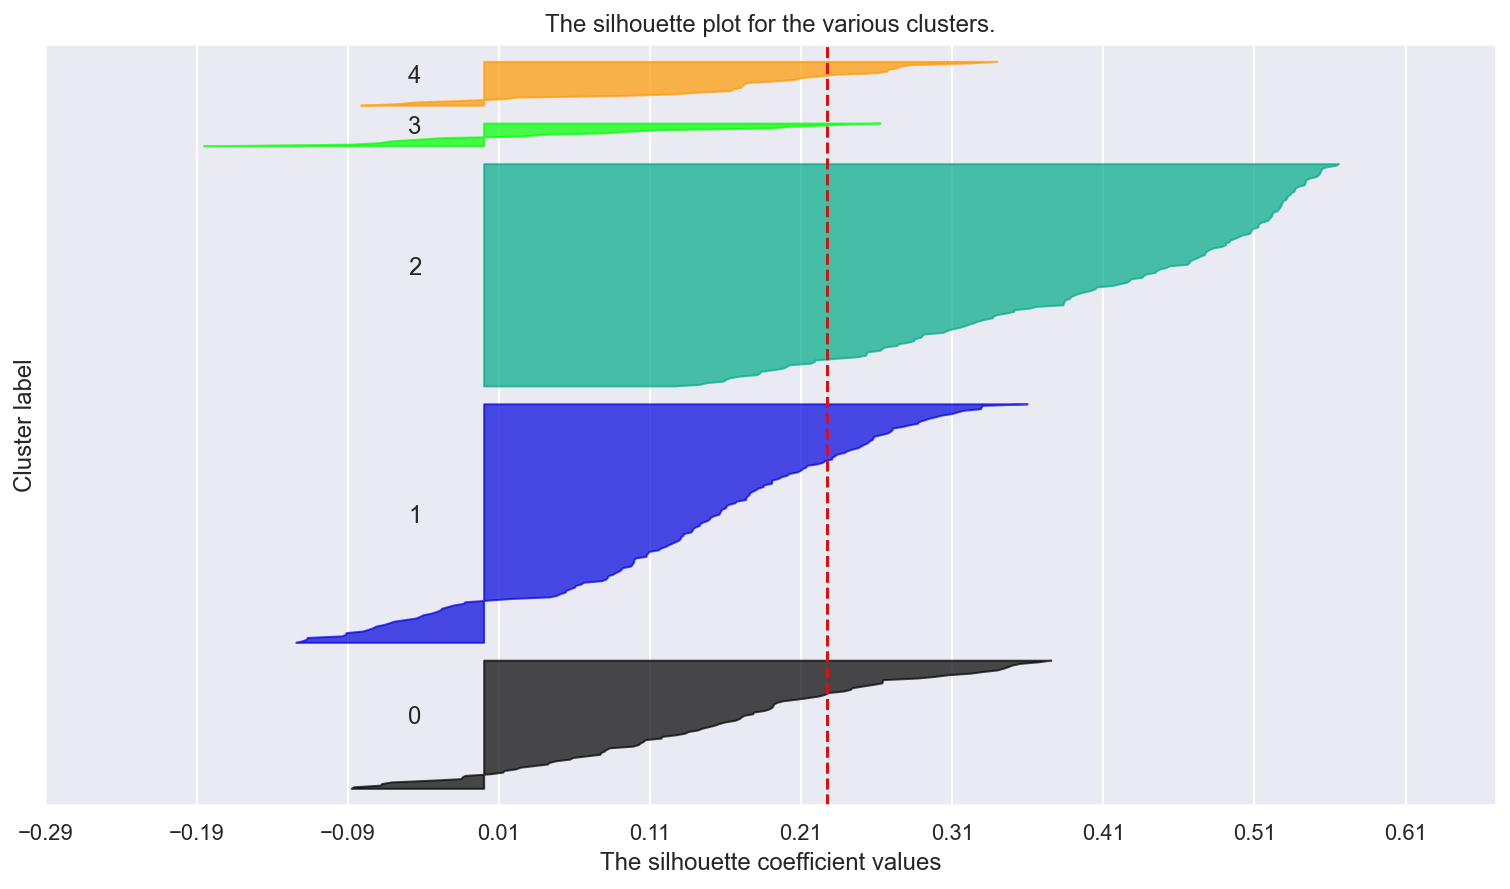

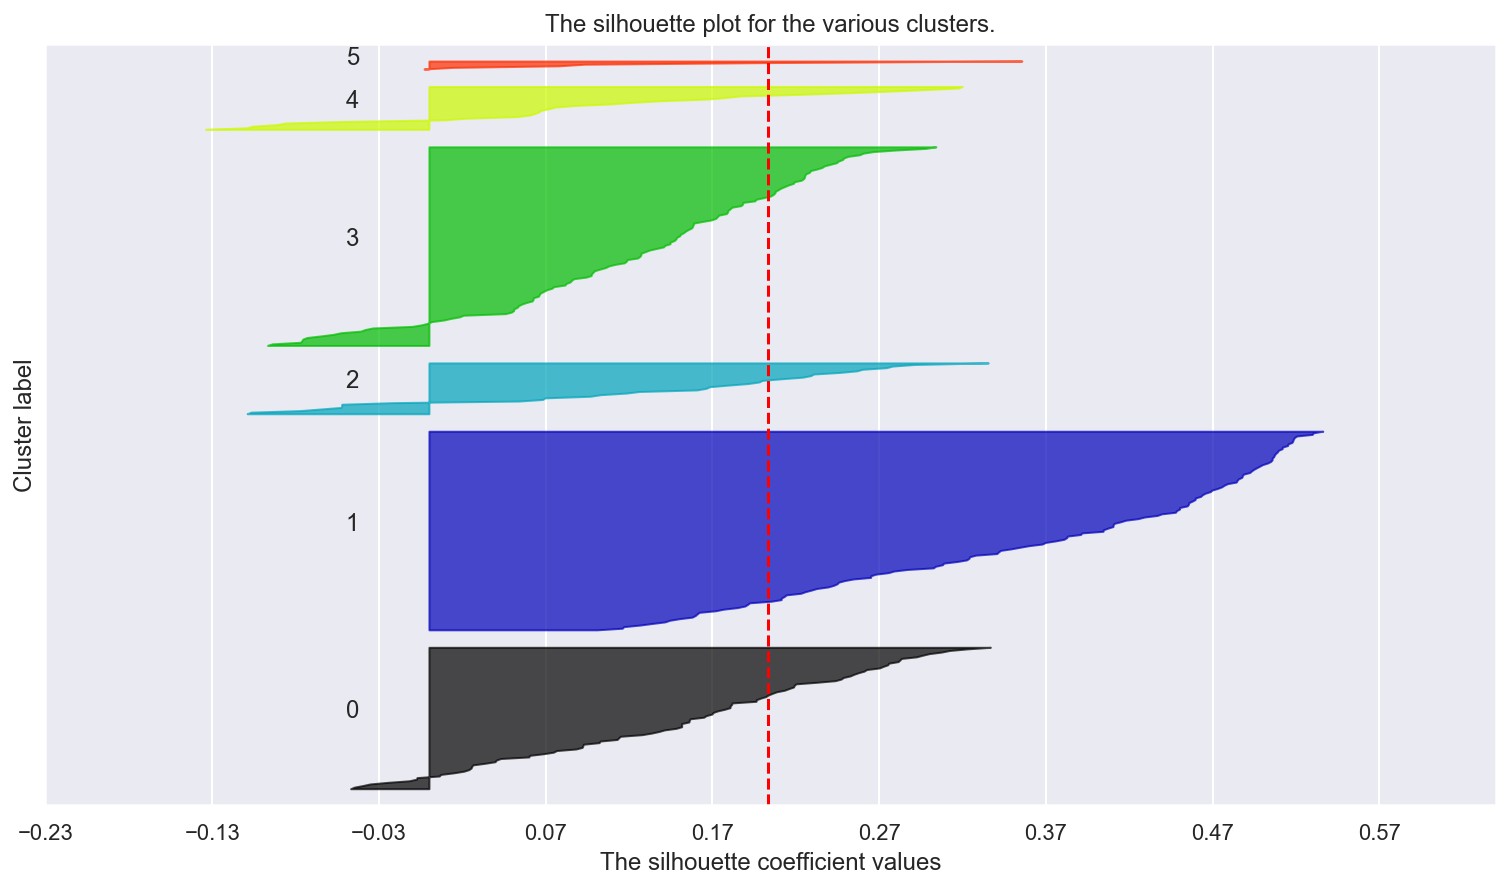

In [87]:
complete_sh_score(df_cluster_pref_family, 7)

#### After looking to the plots, we decided to proceed with 3 clusters

In [88]:
#We set the ‘k-means++’ as the initialization method (init parameter) 
#with 15 number of iterations to choose the best centroid in terms of inertia (n_init parameter).
kmeans_standard = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=15,
    random_state=1
)
kmeans_standard_labels = kmeans_standard.fit_predict(df_cluster_pref_family)

In [89]:
#Check the partion cluster
df_cluster_pref_family['kmeans_standard_labels'] = kmeans_standard_labels
df_cluster_pref_family.groupby('kmeans_standard_labels').count()

ProductFamily_ID,Family_1,Family_10,Family_11,Family_12,Family_13,Family_14,Family_15,Family_16,Family_17,Family_18,...,Family_2,Family_20,Family_21,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8,Family_9
kmeans_standard_labels,,,,,,,,,,,,,,,,,,,,,
0,215,215,215,215,215,215,215,215,215,215,...,215,215,215,215,215,215,215,215,215,215
1,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
2,144,144,144,144,144,144,144,144,144,144,...,144,144,144,144,144,144,144,144,144,144


## Evaluation

#### The R2 is a measure of the homogenity of a cluster solution. 

In [90]:
#Functions to get the R2.

def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable
def adjusted_r2(df, labels):
    """Return the overall adjusted R-squared"""
    
    # 1. calculate sst
    sst = get_ss(df)
    
    # 2. calculate ssw
    grouped_var = df.groupby(labels).var()
    grouped_count = df.groupby(labels).count() - 1
    ssw = np.sum(np.sum(grouped_var * grouped_count))
    
    # 3. return adjusted R-squared
    return 1 - ssw/sst

In [91]:
#R2 for k-means algorithm
adjusted_r2(df_cluster_pref_family,kmeans_standard_labels)

0.5757547379672433

#### Describe clusters - Visualizations

In [92]:
def cluster_profiles(df,label_columns, figsize, compar_titles=None, frequency = True):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    if frequency:
        fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    else:
        fig, axes = plt.subplots(nrows=len(label_columns), ncols=1, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        if frequency:    
            sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-90)
        if frequency:
            ax[1].set_xticklabels(cluster_labels)
            ax[1].set_xlabel("")
            ax[1].set_ylabel("Absolute Frequency")
            ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=10)
    plt.show()

In [93]:
df_cluster_pref_family

ProductFamily_ID,Family_1,Family_10,Family_11,Family_12,Family_13,Family_14,Family_15,Family_16,Family_17,Family_18,...,Family_20,Family_21,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8,Family_9,kmeans_standard_labels
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
POS_1,0.526116,0.784283,-0.380682,0.209723,0.964118,0.170124,0.913177,0.524711,-0.129895,0.857138,...,-0.595420,0.116855,1.234166,0.133179,1.163476,0.435751,0.230051,0.763936,0.768246,2
POS_10,-0.959524,-1.043461,-0.640843,-1.260771,-1.123685,-1.217099,-1.083074,-0.895085,-0.992209,-1.091011,...,-0.691200,-0.809080,-0.428411,-0.605708,-0.030085,-0.721902,-0.463945,-0.591107,-0.988699,0
POS_100,2.016982,0.048272,0.002814,0.610477,1.034189,0.828228,1.227810,0.658495,0.417577,0.877911,...,-0.362783,0.237968,2.139588,1.838202,3.444948,2.123745,-0.127915,1.940544,2.562998,2
POS_101,-0.209012,-0.971886,-0.655740,-0.953373,-0.222568,-0.372060,-0.351430,-0.625671,-0.721616,-0.778911,...,-0.409272,-0.418617,0.311876,-0.640584,-0.056324,-0.522082,-1.229918,-0.347623,-0.326597,0
POS_102,1.446103,-0.007882,-0.416660,0.880742,-0.033863,0.280050,0.772063,0.496815,1.423007,0.374034,...,-0.169293,0.030127,2.795563,1.019679,0.791076,1.147840,0.843618,0.794935,1.167252,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POS_94,-1.206669,-0.738633,-0.755412,-1.026925,-0.740418,-1.116567,-1.192592,-1.075607,-0.841792,-1.280210,...,-0.623542,-0.599210,-1.171481,-0.415145,-0.995543,-1.055429,-1.091306,-1.567957,-1.234728,0
POS_95,-0.366852,-0.144076,-0.660940,-0.389471,-0.118022,-0.195424,-0.473866,-0.304228,-0.580557,-0.661345,...,-0.580162,-0.253689,-0.363358,-0.000479,-0.138136,-0.554159,-0.205118,-0.947436,-0.401214,0
POS_97,-1.080705,-0.929119,-0.671511,-1.098234,-0.907972,-1.038011,-1.199704,-1.007689,-0.783957,-0.940189,...,-0.689220,-0.842825,-0.839768,-0.997686,-0.650810,-0.872594,-0.977964,-1.446778,-1.109444,0


In [94]:
# Define metric features
metric_features = df_cluster_pref_family

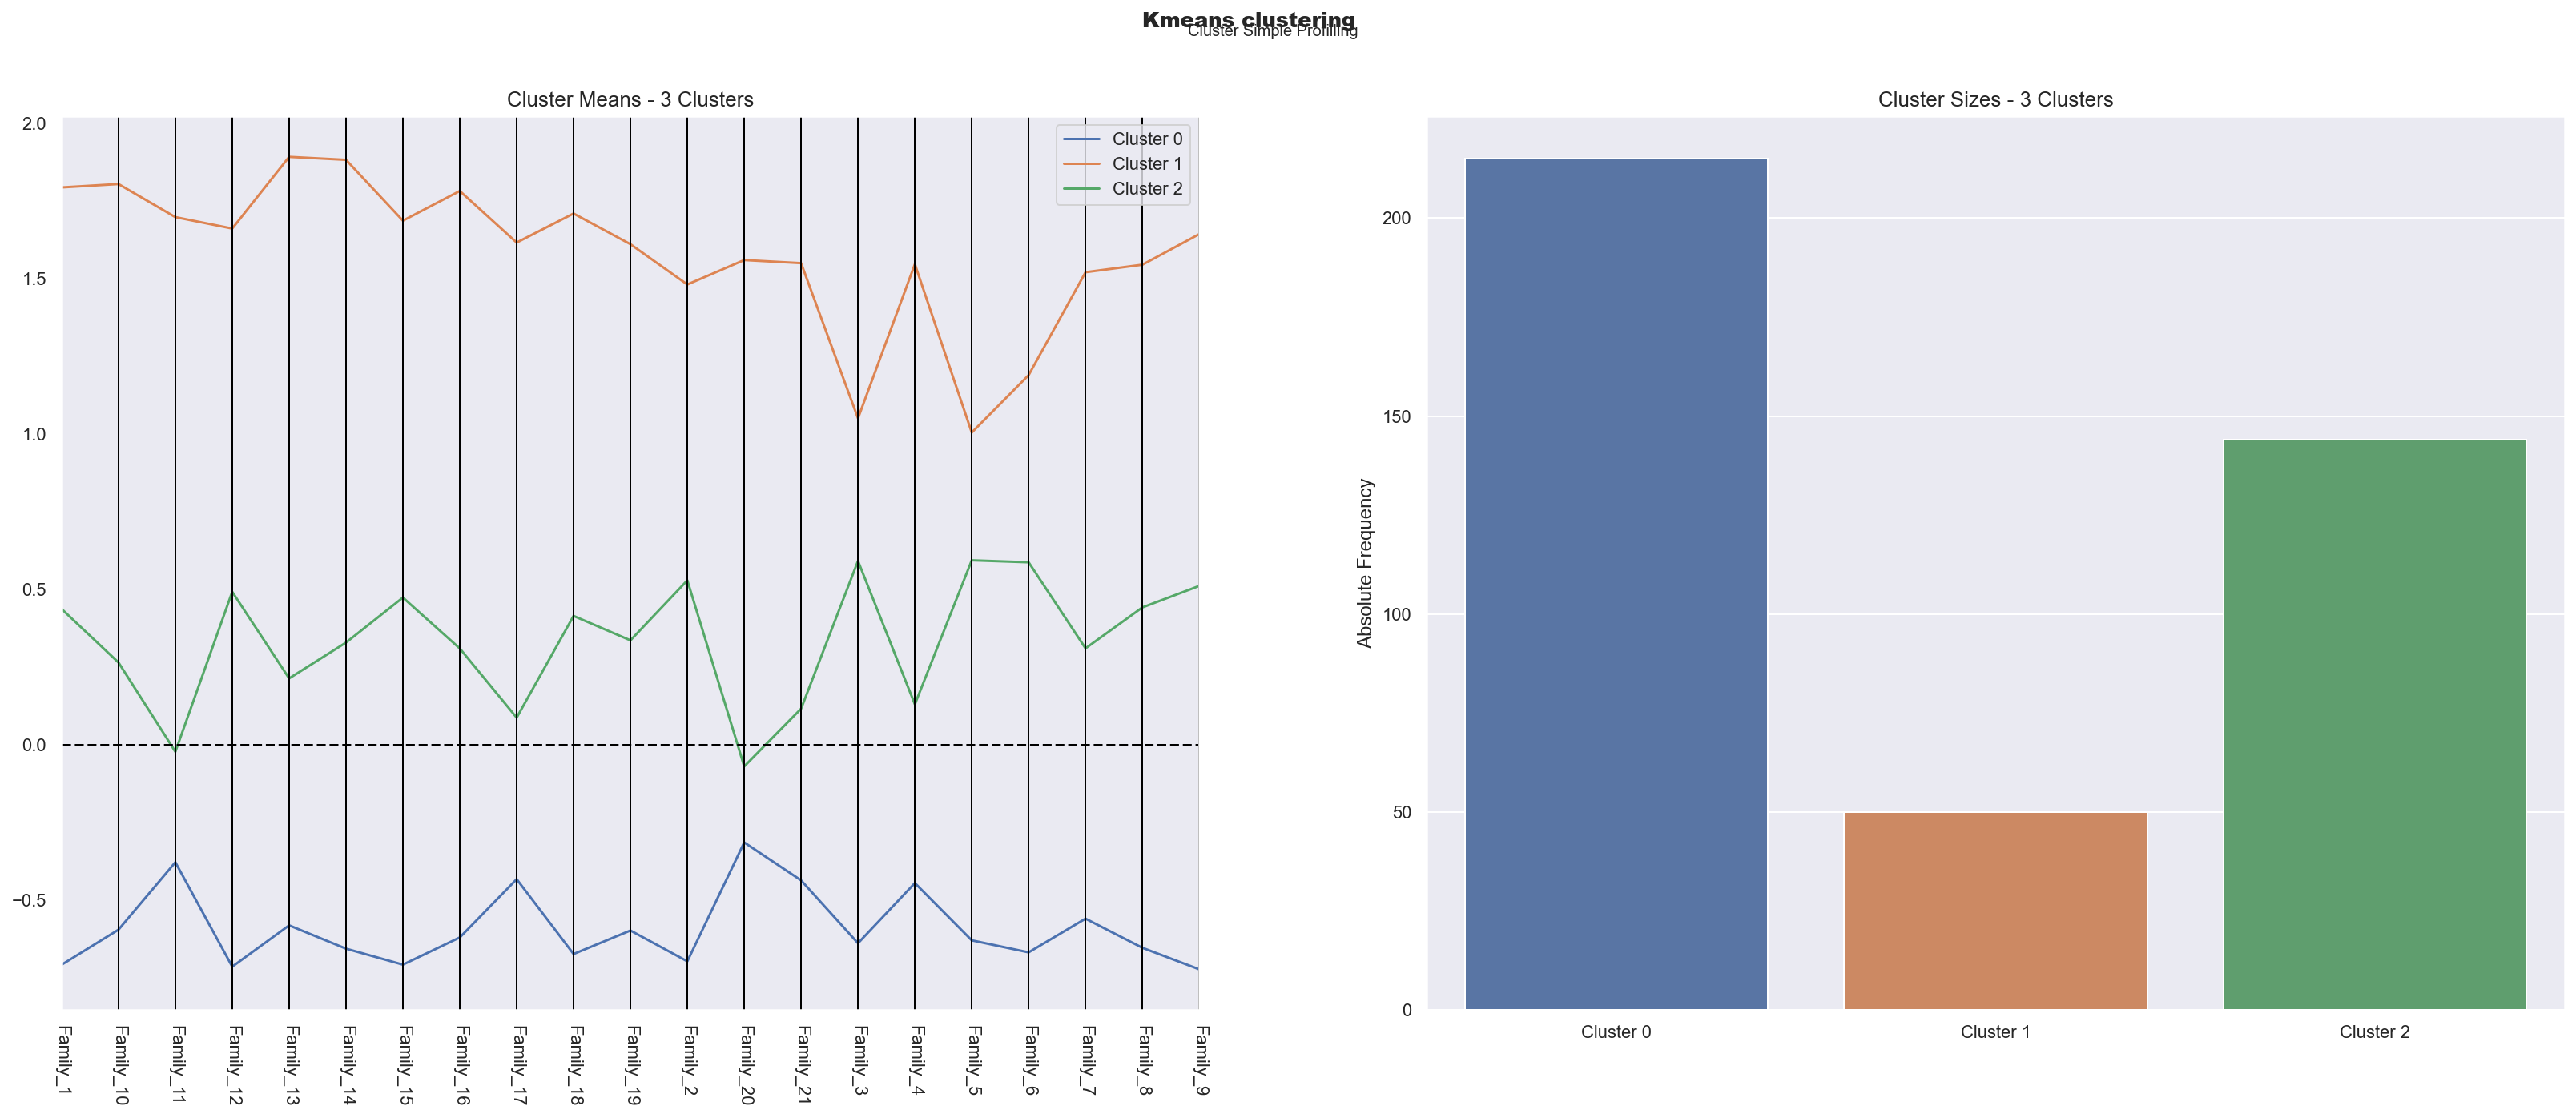

In [95]:
# Profilling cluster
cluster_profiles(
    df = df_cluster_pref_family,
    label_columns = ['kmeans_standard_labels'], 
    figsize = (28, 10), 
    compar_titles = ["Kmeans clustering"]
)

#### T-SNE (t-Distributed Stochastic Neighbor Embedding) is most used for multidimensional visualizations. It has many application but in this work , our objective is visualize clusters within the data and how a cluster solution fits them

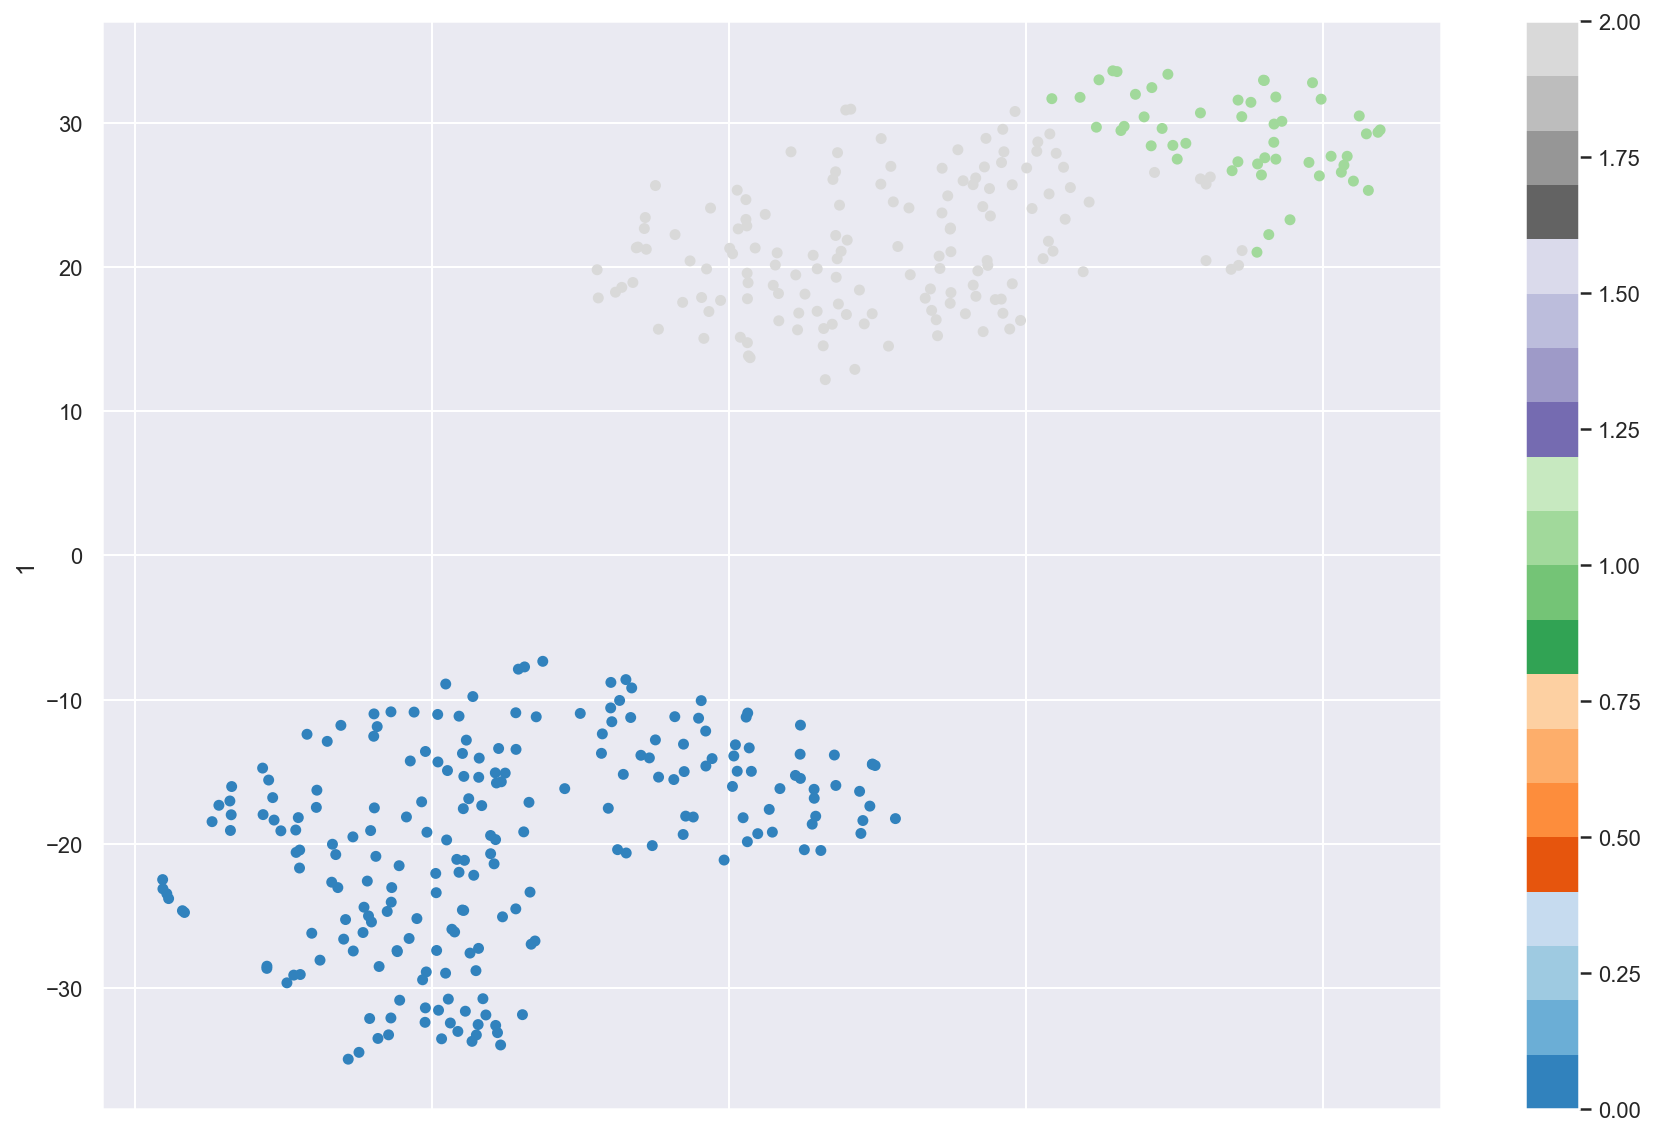

In [96]:
# Run the algorithm, fit and tranform the data
two_dim = TSNE(random_state=42).fit_transform( df_cluster_pref_family)
#Plot the data
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c= df_cluster_pref_family['kmeans_standard_labels'], colormap='tab20c', figsize=(15,10))
plt.show()

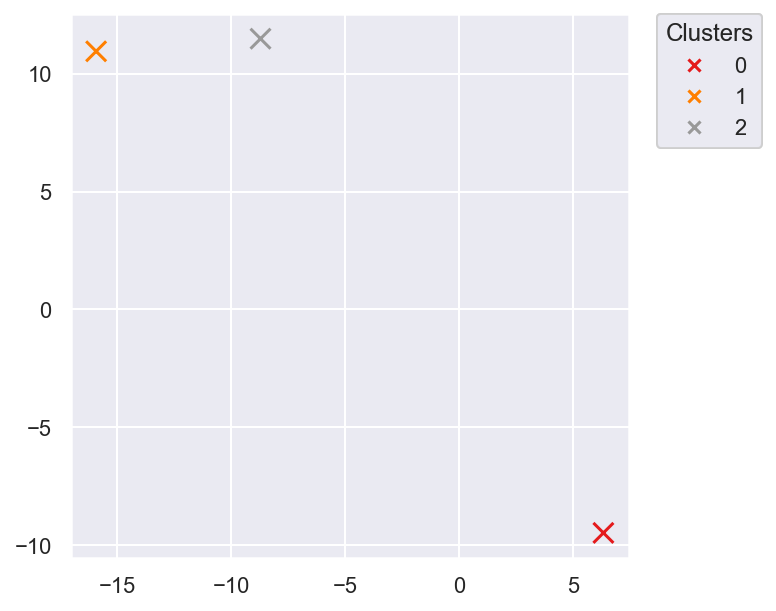

In [97]:
#Visualizing centroids with t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
#Run the algorithm, transform and fit the data
df_tsne = tsne.fit_transform( df_cluster_pref_family)
#Create a data frame to store the results of tnse
df_tsne = pd.DataFrame(df_tsne, index = df_cluster_pref_family.index)\
            .merge(df_cluster_pref_family['kmeans_standard_labels'], right_index = True, left_index = True)
#Store the centroids
centroids = df_tsne.groupby('kmeans_standard_labels').mean()
#Plot the data
fig, ax = plt.subplots(figsize = (5,5))
data = pd.DataFrame(centroids)
scatter = ax.scatter(x = data.iloc[:,0], y = data.iloc[:,1], c = range(3),marker = 'x', s = 100, cmap = 'Set1')
legend1 = ax.legend(*scatter.legend_elements(), title = 'Clusters', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.add_artist(legend1)
plt.show()

In [98]:
df_cluster_pref_family2 =df_cluster_pref_family.reset_index()

In [99]:
df_cluster_pref_family2 = df_cluster_pref_family2[['Point-of-Sale_ID', 'kmeans_standard_labels']]
df_cluster_pref_family2

ProductFamily_ID,Point-of-Sale_ID,kmeans_standard_labels
0,POS_1,2
1,POS_10,0
2,POS_100,2
3,POS_101,0
4,POS_102,2
...,...,...
404,POS_94,0
405,POS_95,0
406,POS_97,0
407,POS_98,0


In [100]:
df_cluster_pref_family2.to_csv(os.path.join("dfcluster_pref_family .csv"), index=False)

After running the 3 tentatives of cluster we decide to keep only the cluster based on values. 
The cluster based on values presented the better results in terms of metrics and visualizations. 
We had the opportunity to do some analysis in power BI to compare the results and we detect:
The cluster based on categories don't present good results because: a) the category 178 is very representative overall so its not help to segregate preferences and the other categories are to much distributed so it's generate sparsity.
Regarding cluster based on family, it's presented some good results, but when it is compared with cluster based on values is worst. When we compare the results in power BI, we also detect that in terms of preferences of products the cluster based on values is very similar to the cluster based on family.